In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import hilbert
from scipy.signal import butter, lfilter

# 定义缺陷

In [2]:
# 100.csv
n = np.array([8] * 8)
fr = np.array([35, 35, 35, 35, 37.5, 37.5, 40, 40])
d = np.array([7.92] * 8)
D = np.array([34.55] * 8)
A = np.zeros(8)

In [3]:
BPFO = n * fr / 2 * (1 - d / D * np.cos(A))
BPFI = n * fr / 2 * (1 + d / D * np.cos(A))
BSF = fr / 2 * D / d * (1 - d / D * np.cos(A)) ** 2
FTF = fr / 2 * (1 - d / D * np.cos(A))

In [4]:
print(BPFO[0], BPFI[0], BSF[0], FTF[0])

107.90738060781476 172.09261939218524 45.35311782806355 13.488422575976845


# 对第一个数据进行探索

## 导入数据

In [5]:
data = pd.read_csv('./VibrationSignal/100.csv')
Horizontal_vibration_signals = data.loc[:, 'Horizontal_vibration_signals']
# type(Horizontal_vibration_signals)
Horizontal_vibration_signals_array = Horizontal_vibration_signals.to_numpy()
# type(Horizontal_vibration_signals_array)
# Horizontal_vibration_signals_array

Text(0, 0.5, 'Acceleration(g)')

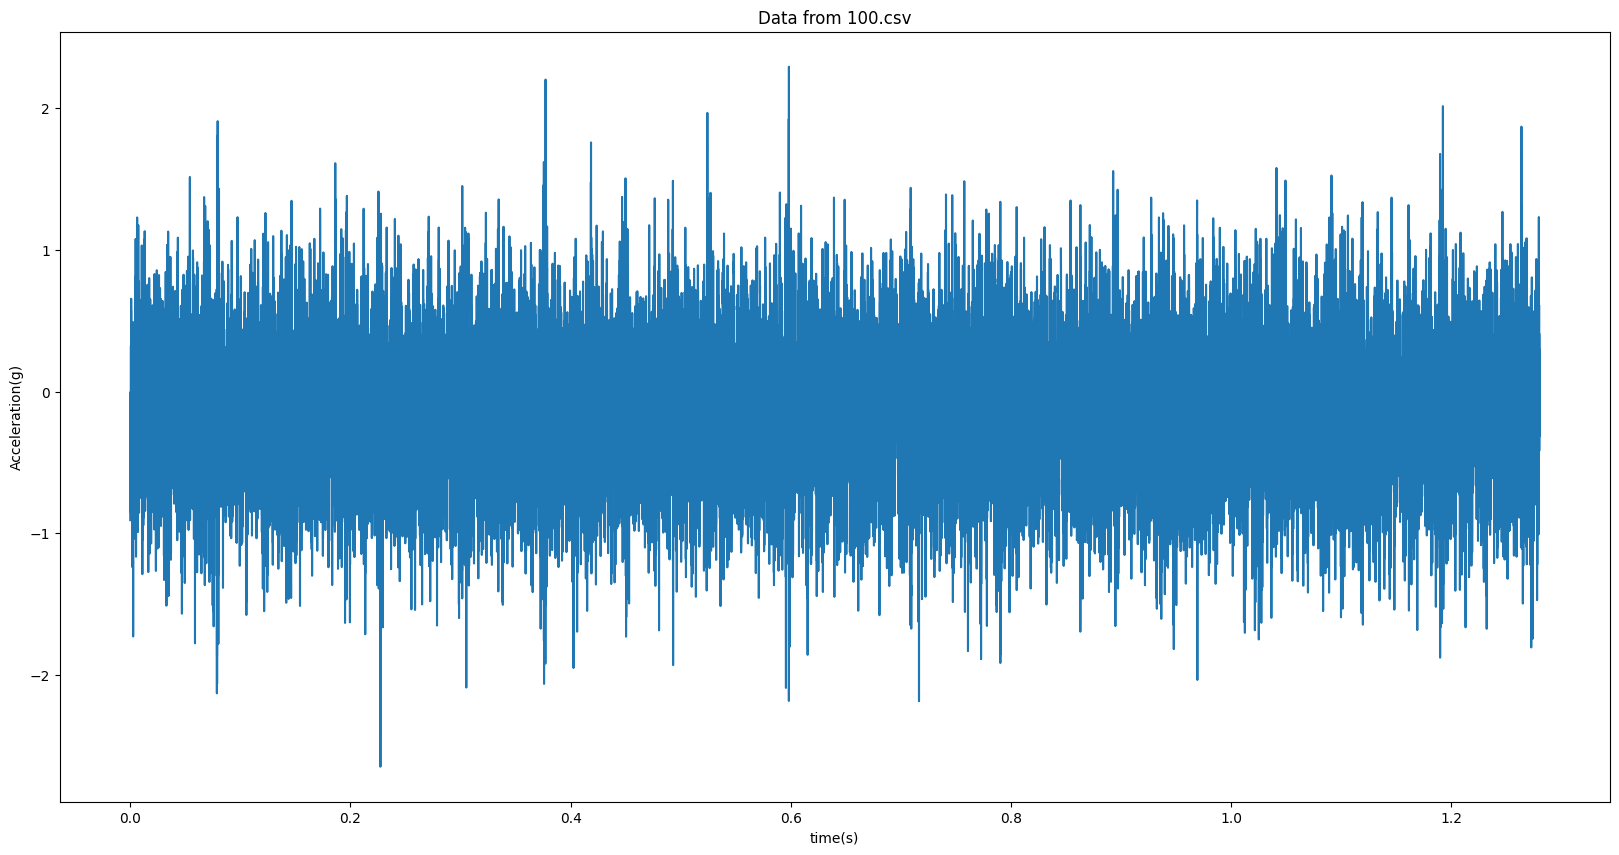

In [6]:
nfftto = 256000
fs = 25.6e3

n = np.arange(len(Horizontal_vibration_signals_array))
plt.figure(figsize=(20, 10))
plt.plot(n/fs, Horizontal_vibration_signals_array)
plt.title("Data from 100.csv")
plt.xlabel("time(s)")
plt.ylabel("Acceleration(g)")

## 对信号进行频域分析

In [7]:
def fft_signal(signal, fs):
    """
    对时域信号进行快速傅里叶变换(FFT)。

    参数:
    signal (ndarray): 时域信号
    fs (float): 采样频率

    返回:
    freqs (ndarray): 频率值
    fft_vals (ndarray): FFT结果
    """
    n = len(signal)
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1/fs)

    return freqs, fft_vals


def plot_fft(freqs, fft_vals, data_No=0, title='FFT Spectrum', xlabel='Frequency (Hz)', ylabel='Amplitude'):
    """
    绘制FFT结果的图像。

    参数:
    freqs (ndarray): 频率值
    fft_vals (ndarray): FFT结果
    title (str, 可选): 图像标题
    xlabel (str, 可选): x轴标签
    ylabel (str, 可选): y轴标签
    """

    n = len(fft_vals)
    half_len = n // 2
    freqs = freqs[:half_len]
    fft_vals = fft_vals[:half_len]

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, np.abs(fft_vals))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 200)
    plt.axvline(BPFO[data_No], color='r', linestyle='--')
    plt.axvline(BPFI[data_No], color='r', linestyle='--')
    plt.axvline(BSF[data_No], color='r', linestyle='--')
    plt.axvline(FTF[data_No], color='r', linestyle='--')
    plt.grid(True)
    plt.show()

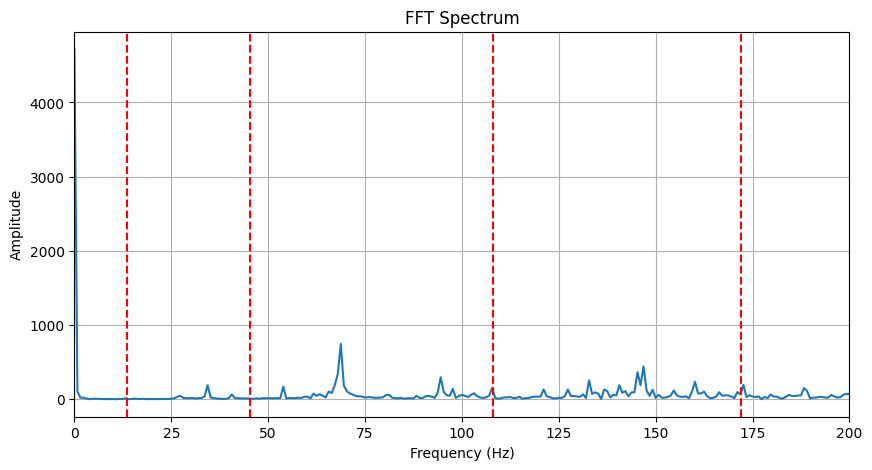

In [8]:
# 计算FFT
freqs, fft_vals = fft_signal(Horizontal_vibration_signals_array, fs)

# 绘制FFT结果
plot_fft(freqs, fft_vals, data_No=0)

## 计算功率谱密度

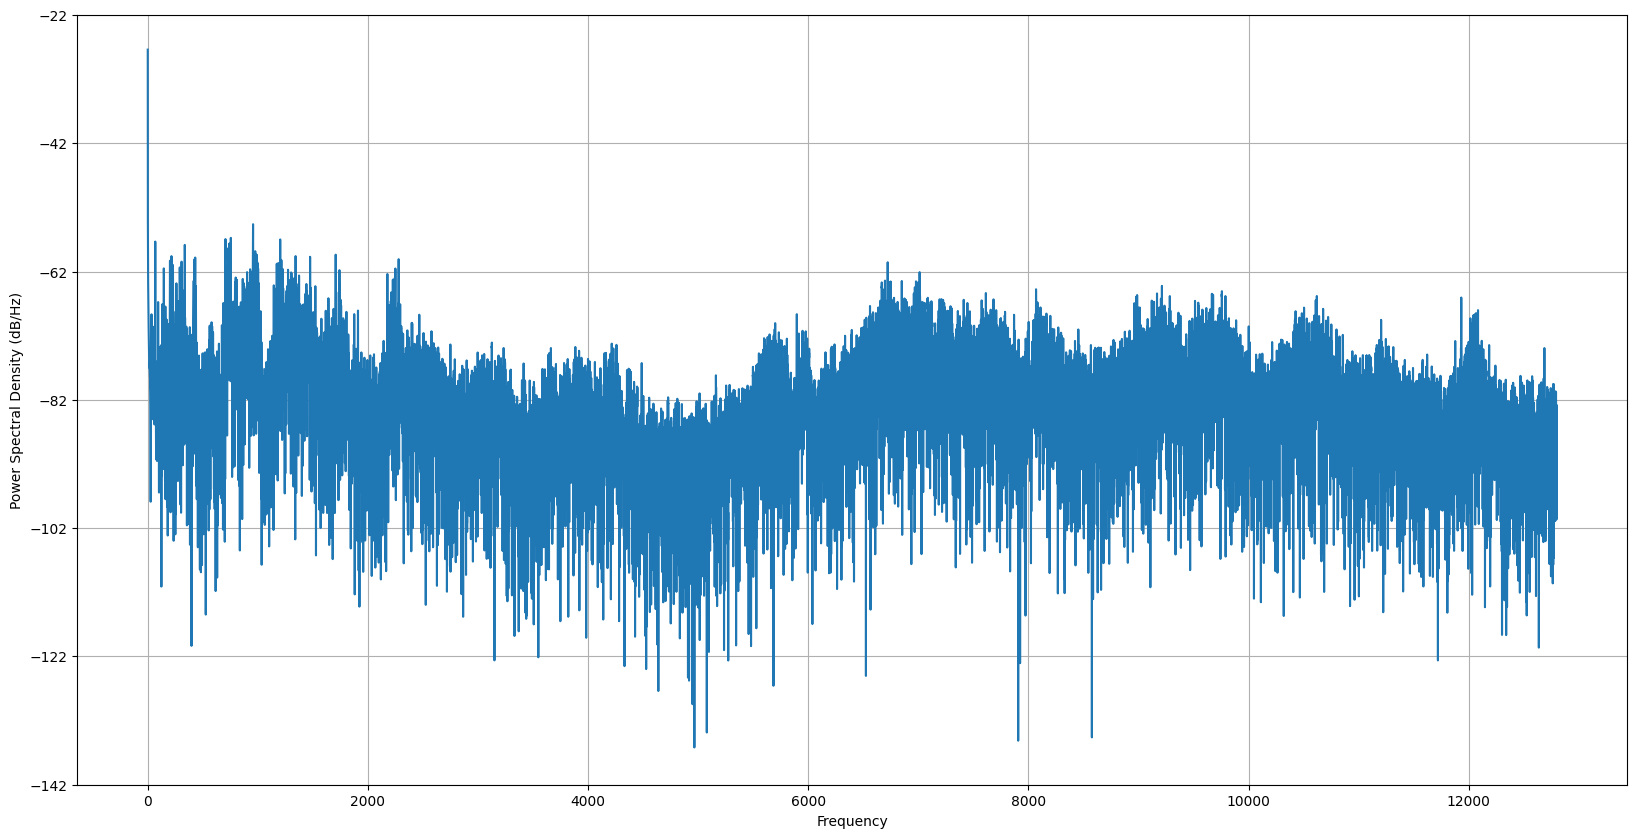

In [9]:
plt.figure(figsize=(20, 10))
[Pxx1, f1] = plt.psd(Horizontal_vibration_signals_array,                       # 随机信号
                     NFFT=nfftto,               # 每个窗的长度
                     Fs=fs,                   # 采样频率
                     detrend='mean',          # 去掉均值
                     window=np.hanning(nfftto),  # 加汉尼窗
                     noverlap=int(nfftto*3/4),  # 每个窗重叠75%的数据
                     sides='onesided')        # 求双边谱

In [10]:
def power_spectral_density(signal, fs, window='hann', nperseg=256000, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, **kwargs):
    """
    计算信号的功率谱密度。

    参数:
    signal (array_like): 时域信号
    fs (float): 采样频率
    window (str or tuple or array_like, 可选): 窗函数
    nperseg (int, 可选): FFT长度
    noverlap (int, 可选): 重叠的样本数
    nfft (int, 可选): FFT点数
    detrend (str or function or False, 可选): 指定函数将被用于去除信号的趋势
    return_onesided (bool, 可选): 如果为True,则返回单侧频谱
    scaling (str, 可选): 指定如何缩放结果
    axis (int, 可选): 沿着哪个轴进行计算

    返回:
    freqs (ndarray): 频率值
    psd (ndarray): 功率谱密度值
    """
    freqs, psd = welch(signal, fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft,
                       detrend=detrend, return_onesided=return_onesided, scaling=scaling, axis=axis, **kwargs)
    return freqs, psd


def plot_power_spectral_density(freqs, psd, fs, data_No=0, title='Power Spectral Density', xlabel='Frequency (Hz)', ylabel='Power Spectral Density(DB/Hz)'):
    """
    绘制功率谱密度图像。

    参数:
    freqs (ndarray): 频率值
    psd (ndarray): 功率谱密度值
    fs (float): 采样频率
    title (str, 可选): 图像标题
    xlabel (str, 可选): x轴标签
    ylabel (str, 可选): y轴标签
    """
    # 计算频率范围
    freq_range = freqs[-1]

    # 将功率谱密度转换为分贝/赫兹
    # psd_db = 10 * np.log10(psd / (fs / 2))
    psd_db = psd

    # 创建图像
    fig, ax = plt.subplots(figsize=(15, 6))

    # 绘制功率谱密度曲线
    ax.plot(freqs, psd_db)

    # 设置标题和标签
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # 设置x轴范围
    ax.set_xlim(0, 200)

    ax.axvline(BPFO[data_No], color='r', linestyle='--')
    ax.axvline(BPFI[data_No], color='r', linestyle='--')
    ax.axvline(BSF[data_No], color='r', linestyle='--')
    ax.axvline(FTF[data_No], color='r', linestyle='--')

    # 显示图像
    plt.show()

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


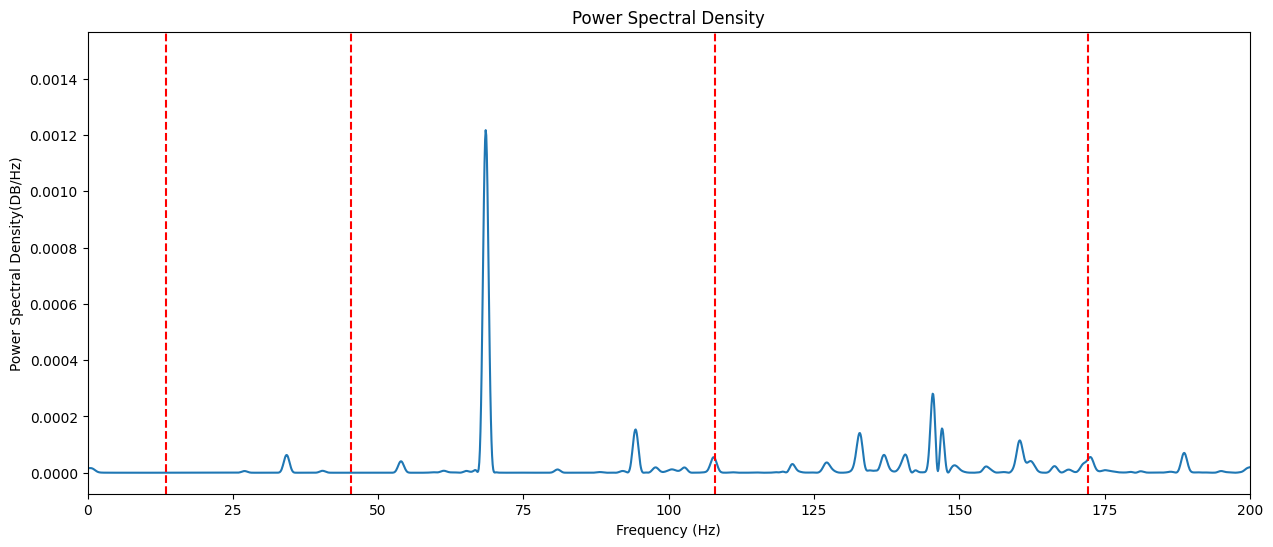

In [11]:
freqs, psd = power_spectral_density(
    Horizontal_vibration_signals_array, fs, nfft=nfftto)
plot_power_spectral_density(freqs, psd, fs, data_No=0)
# print(freqs)

## 计算包络信号

这样直接计算包络信号是错误的，效果非常的差

In [12]:
def envelope(signal, fs, axis=-1):
    """
    计算信号的包络信号。

    参数:
    signal (array_like): 时域信号
    fs (float): 采样频率
    axis (int, 可选): 沿着哪个轴进行计算

    返回:
    env (ndarray): 包络信号
    """
    # 计算解析信号
    analytic_signal = hilbert(signal, axis=axis)

    # 计算包络信号
    env = np.abs(analytic_signal)

    return env

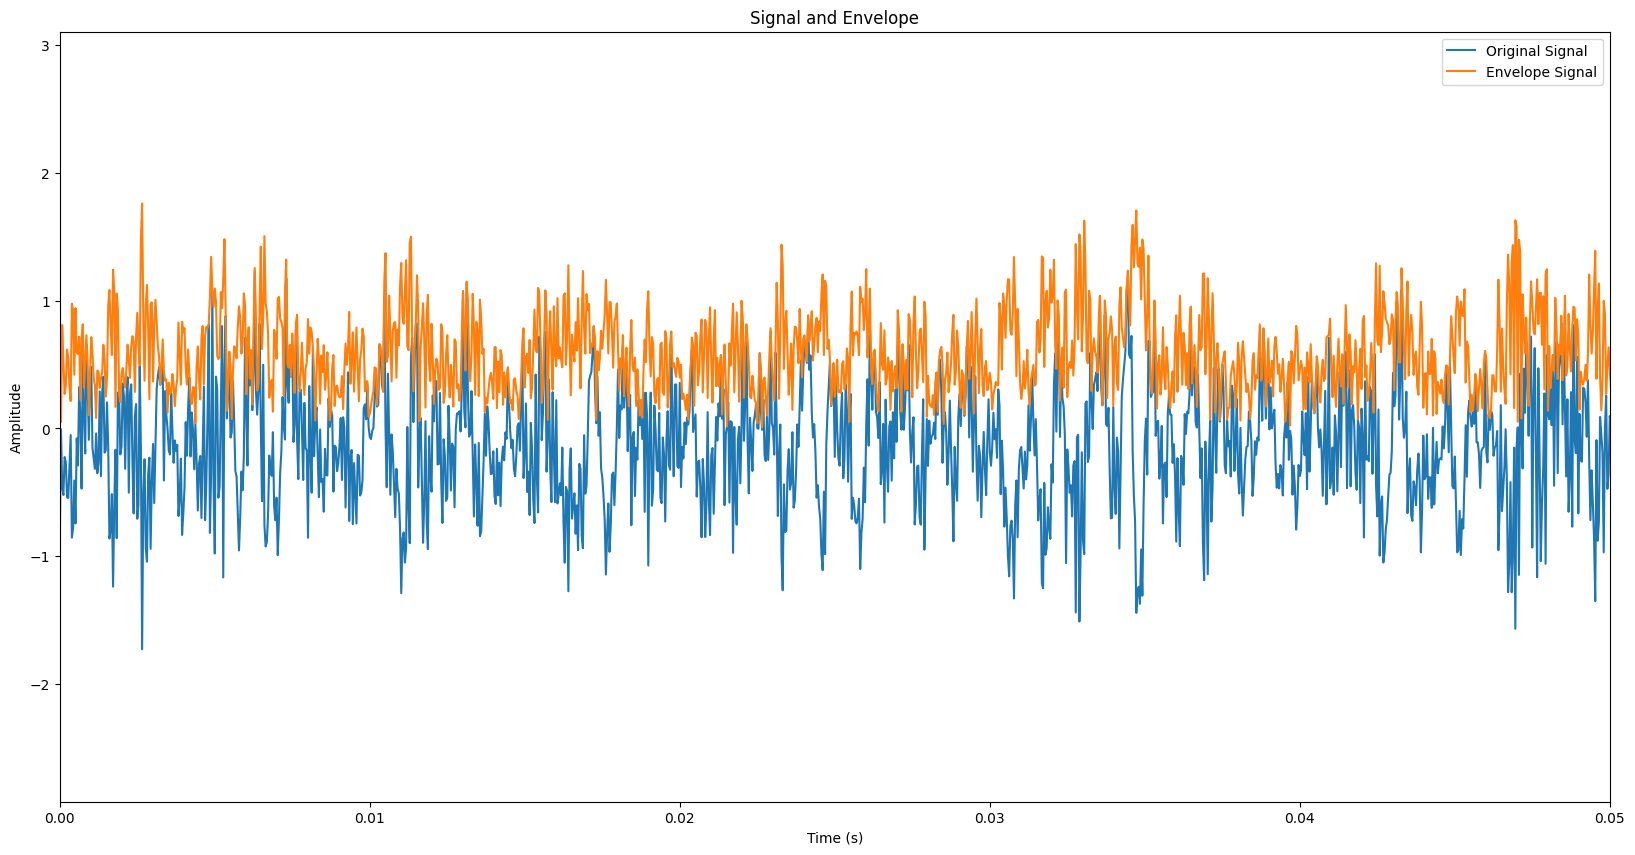

In [13]:
# 计算包络信号
env = envelope(Horizontal_vibration_signals_array, fs)

# 创建时间向量
time = np.arange(len(Horizontal_vibration_signals_array)) / fs

# 绘制原始信号和包络信号
plt.figure(figsize=(20, 10))
plt.plot(time, Horizontal_vibration_signals_array, label='Original Signal')
plt.plot(time, env, label='Envelope Signal')
plt.xlim(0, 0.05)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal and Envelope')
plt.legend()
plt.show()

不过可以看出，在通过获取包络信号来滤除原本信号中的部分高频成分后，我们信号中的低频部分变得清晰了很多。

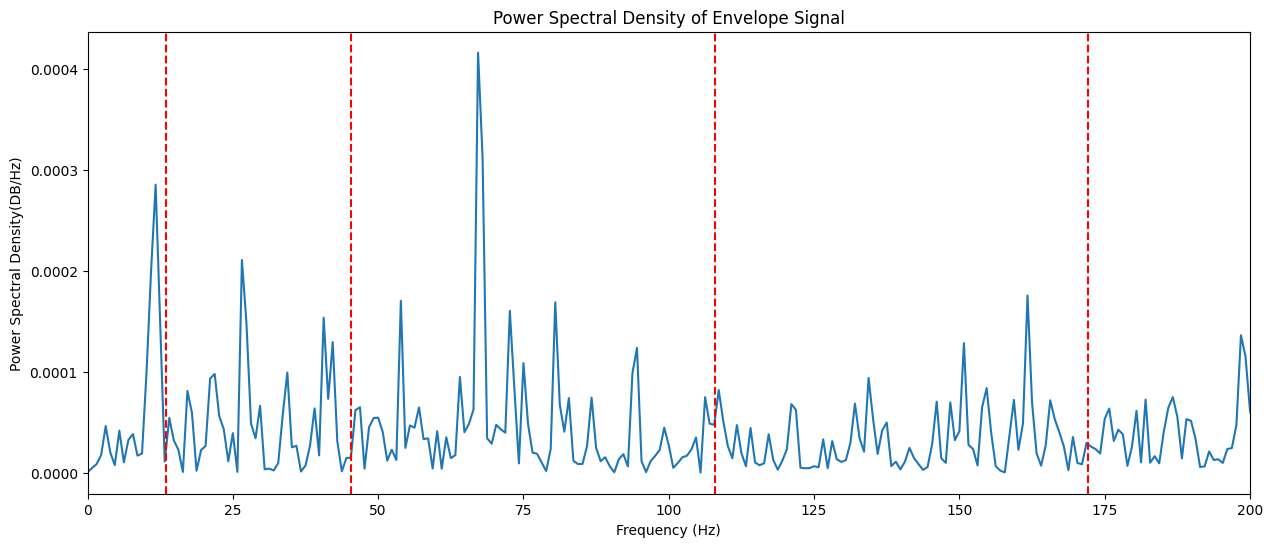

In [14]:
freqs_env, psd_env = power_spectral_density(env, fs)
plot_power_spectral_density(freqs_env, psd_env, fs, data_No=0,
                            title='Power Spectral Density of Envelope Signal')

进行包络分析

In [15]:
def envelope_analysis(signal, fs, low_freq, high_freq, order=4):
    """
    对信号进行包络分析,包括带通滤波和包络提取。

    参数:
    signal (ndarray): 时域信号
    fs (float): 采样频率
    low_freq (float): 带通滤波器的低截止频率
    high_freq (float): 带通滤波器的高截止频率
    order (int, 可选): 滤波器阶数

    返回:
    env (ndarray): 包络信号
    """
    # 设计带通滤波器
    nyq = 0.5 * fs
    low = low_freq / nyq
    high = high_freq / nyq
    b, a = butter(order, [low, high], btype='band')

    # 对信号进行带通滤波
    filtered_signal = lfilter(b, a, signal)

    # 计算包络信号
    analytic_signal = hilbert(filtered_signal)
    env = np.abs(analytic_signal)

    return env


def spectral_kurtosis(signal, fs, nfft=None, noverlap=None, window='hann'):
    """
    计算信号的谱峭度。

    参数:
    signal (ndarray): 时域信号
    fs (float): 采样频率
    nfft (int, 可选): FFT点数
    noverlap (int, 可选): 重叠的样本数
    window (str or tuple or array_like, 可选): 窗函数

    返回:
    freqs (ndarray): 频率值
    kurtosis (ndarray): 谱峭度值
    """
    freqs, psd = welch(signal, fs, nfft=nfft, noverlap=noverlap, window=window)
    kurtosis = psd ** 2 / np.mean(psd ** 2, axis=-1, keepdims=True)
    return freqs, kurtosis

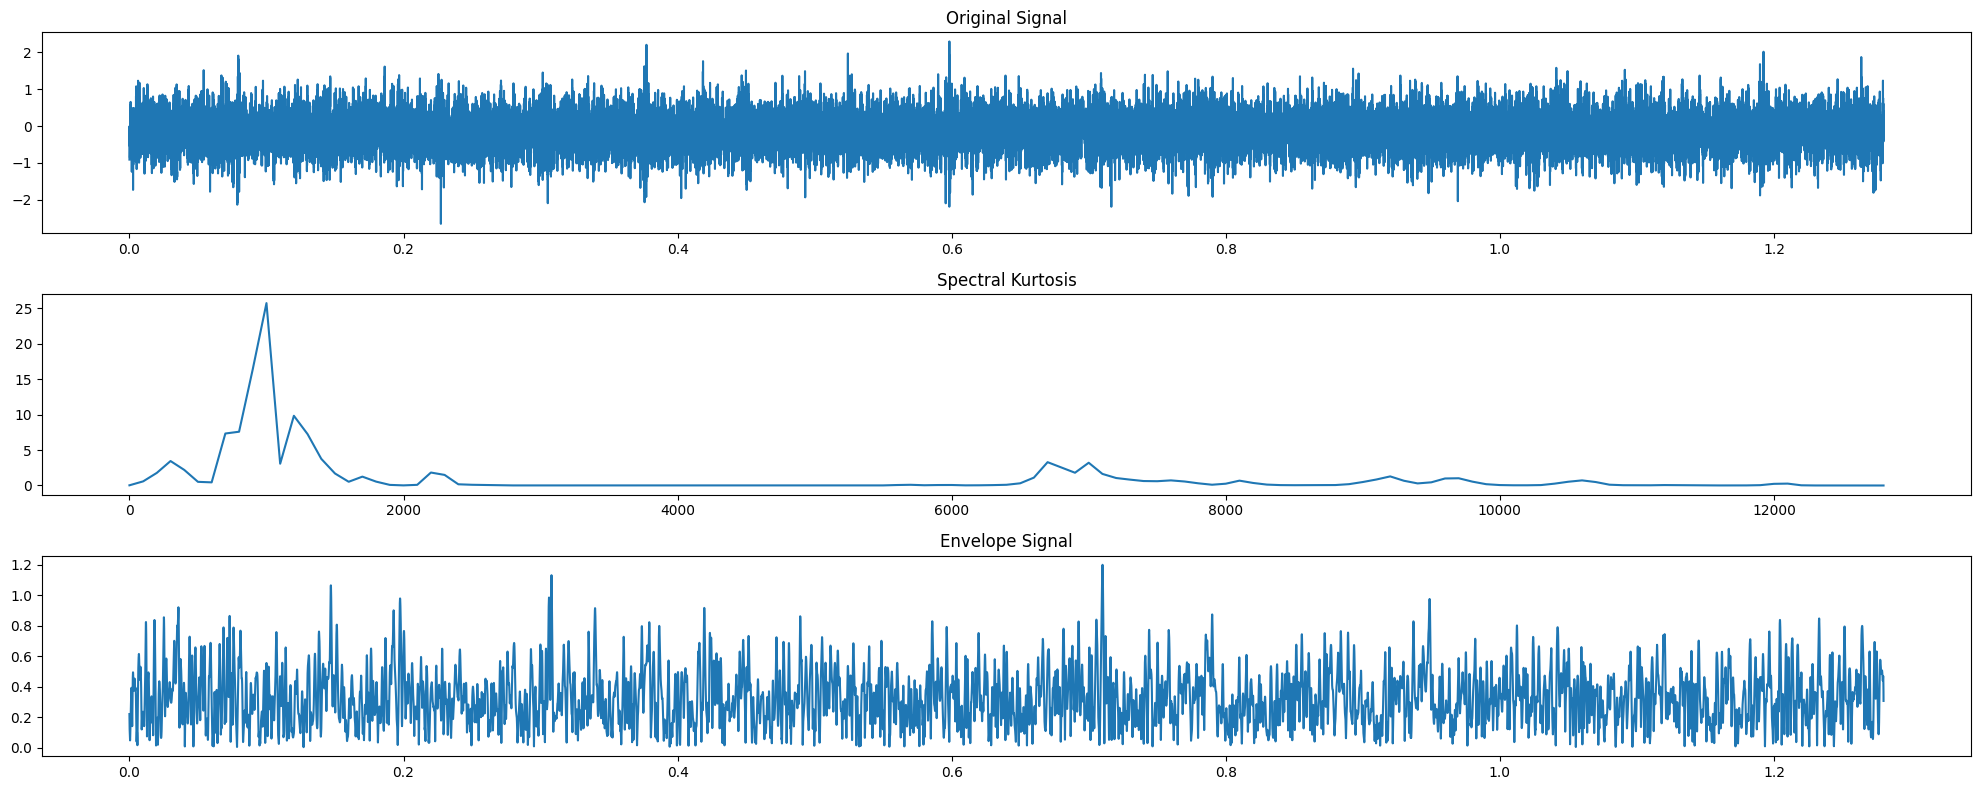

In [16]:
# 计算谱峭度
freqs, kurtosis = spectral_kurtosis(Horizontal_vibration_signals_array, fs)

# print(freqs)
# 确定高频共振脉冲的频带
max_kurtosis_idx = np.argmax(kurtosis)
# print(max_kurtosis_idx)
low_freq = freqs[max_kurtosis_idx - 5]
high_freq = freqs[max_kurtosis_idx + 5]

# 包络分析，并在同一个函数中实现带通滤波
env = envelope_analysis(
    Horizontal_vibration_signals_array, fs, low_freq, high_freq)

# 绘制结果
plt.figure(figsize=(20, 8))
plt.subplot(3, 1, 1)
plt.plot(n/fs, Horizontal_vibration_signals_array)
plt.title('Original Signal')
plt.subplot(3, 1, 2)
plt.plot(freqs, kurtosis)
plt.title('Spectral Kurtosis')
plt.subplot(3, 1, 3)
plt.plot(n/fs, env)
plt.title('Envelope Signal')
plt.tight_layout()
plt.show()

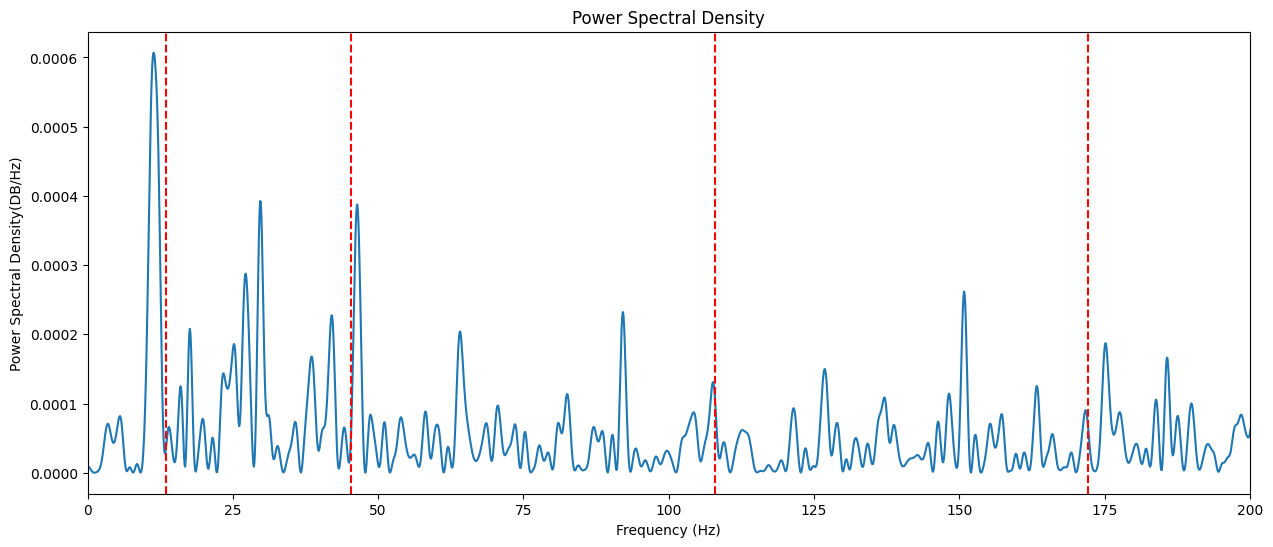

In [17]:
freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)
plot_power_spectral_density(freqs_env, psd_env, fs, data_No=0)

In [18]:
# def plot_power_spectral_density_all(freqs, psd, fs, data_No=0, fault_type=FTF, title='Power Spectral Density', xlabel='Frequency (Hz)', ylabel='Power Spectral Density(DB/Hz)'):
#     """
#     绘制功率谱密度图像,并在整数倍的频率处绘制虚线。

#     参数:
#     freqs (ndarray): 频率值
#     psd (ndarray): 功率谱密度值
#     fs (float): 采样频率
#     title (str, 可选): 图像标题
#     xlabel (str, 可选): x轴标签
#     ylabel (str, 可选): y轴标签
#     """
#     # 计算频率范围
#     freq_range = freqs[-1]

#     # 将功率谱密度转换为分贝/赫兹
#     # psd_db = 10 * np.log10(psd / (fs / 2))
#     psd_db = psd

#     # 创建图像
#     fig, ax = plt.subplots(figsize=(15, 6))

#     # 绘制功率谱密度曲线
#     ax.plot(freqs, psd_db)

#     # 绘制整数倍的频率虚线
#     for i in range(1, 30):
#         ax.axvline(i * fault_type[data_No], color='r', linestyle='--')

#     # 设置标题和标签
#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)

#     # 设置x轴范围
#     ax.set_xlim(0, 300)

# # 显示图像
# plt.show()

def plot_power_spectral_density_all(freqs, psd, fs, data_No=0, fault_type=None, title='Power Spectral Density', xlabel='Frequency (Hz)', ylabel='Power Spectral Density(DB/Hz)', ax=None):
    """
    绘制功率谱密度图像,并在整数倍的频率处绘制虚线。

    参数:
    freqs (ndarray): 频率值
    psd (ndarray): 功率谱密度值
    fs (float): 采样频率
    data_No (int, 可选): 数据索引,默认为 0
    fault_type (list or ndarray, 可选): 故障频率基准值列表
    title (str, 可选): 图像标题
    xlabel (str, 可选): x轴标签
    ylabel (str, 可选): y轴标签
    ax (matplotlib.axes.Axes, 可选): 要绘制图像的子图轴
    """
    # 计算频率范围
    freq_range = freqs[-1]

    # 将功率谱密度转换为分贝/赫兹
    # psd_db = 10 * np.log10(psd / (fs / 2))
    psd_db = psd

    # 如果没有提供子图轴,则创建一个新的图像
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # 绘制功率谱密度曲线
    ax.plot(freqs, psd_db)

    # 如果提供了故障频率基准值列表,则绘制整数倍的频率虚线
    if fault_type is not None:
        for i in range(1, 30):
            ax.axvline(i * fault_type[data_No], color='r', linestyle='--')

    # 设置标题和标签
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # 设置x轴范围
    ax.set_xlim(0, 300)

    # 如果没有提供子图轴,则显示图像
    if ax is None:
        plt.show()

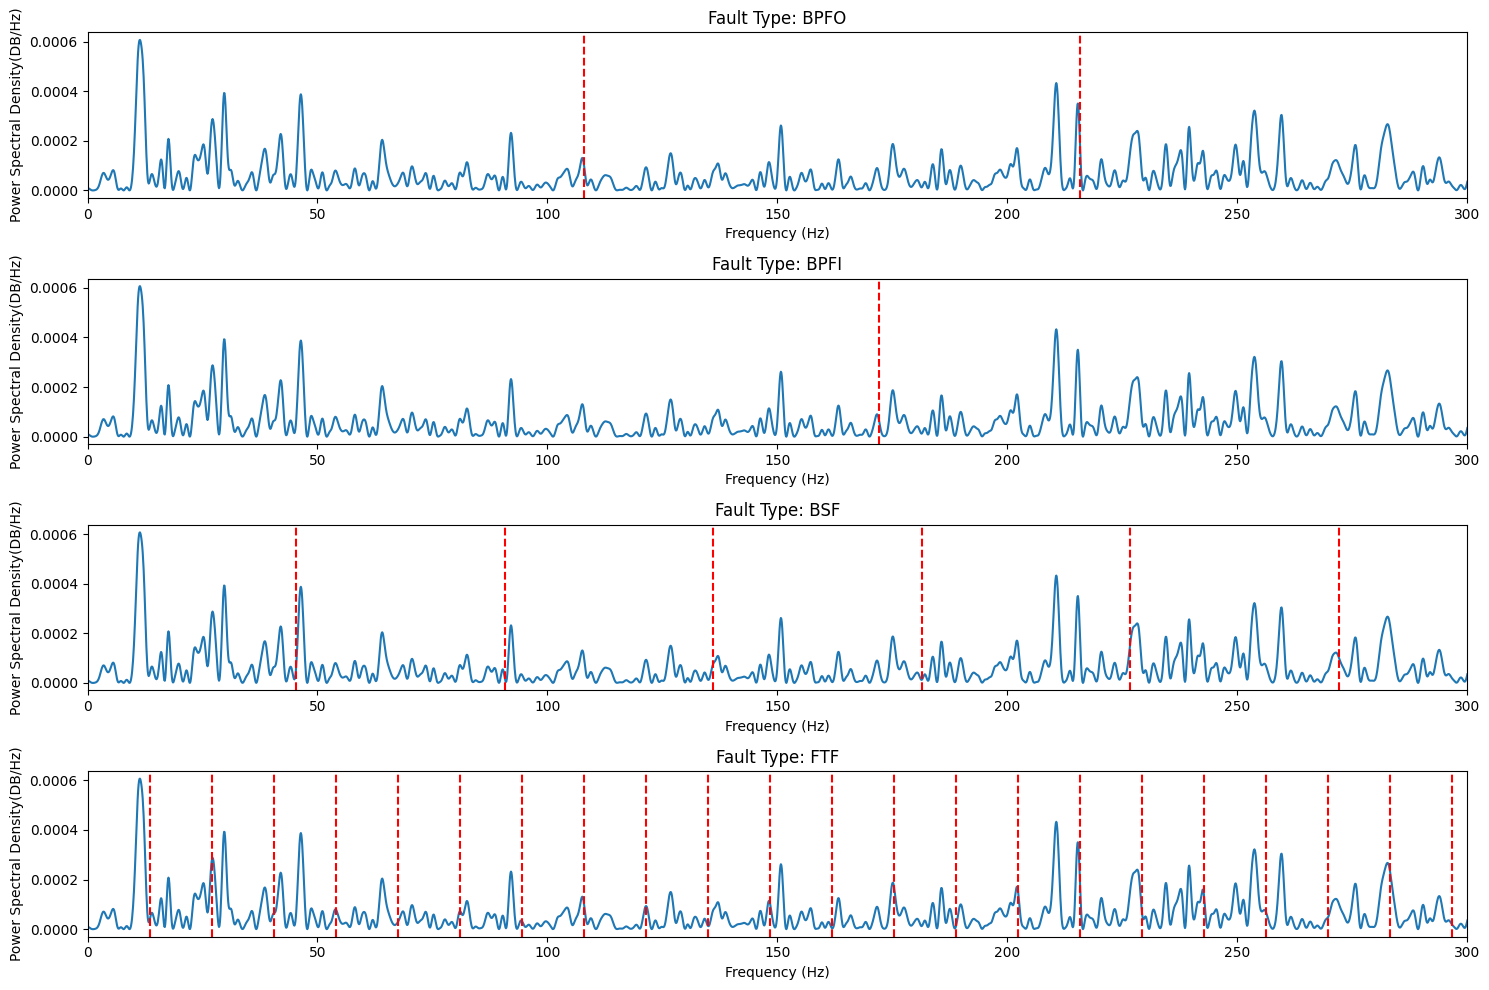

In [19]:
# 创建一个字典,将数组名称与数组关联
fault_types = {'BPFO': BPFO, 'BPFI': BPFI, 'BSF': BSF, 'FTF': FTF}

fig, axs = plt.subplots(4, 1, figsize=(15, 10))
axs = axs.ravel()

for i, (name, type) in enumerate(fault_types.items()):
    plot_power_spectral_density_all(
        freqs_env, psd_env, fs, data_No=0, fault_type=type, ax=axs[i])
    axs[i].set_title(f'Fault Type: {name}')

plt.tight_layout()
plt.show()

Let's apply that to all the csv!

In [20]:
# 将上面部分函数封装成一个函数，输入 csv 名称，绘制出四种故障的频率图像
def plot_all_freqs(csv_name, data_no):
    data = pd.read_csv(f'./VibrationSignal/{csv_name}')
    Horizontal_vibration_signals = data.loc[:, 'Horizontal_vibration_signals']
    Horizontal_vibration_signals_array = Horizontal_vibration_signals.to_numpy()

    freqs, fft_vals = fft_signal(Horizontal_vibration_signals_array, fs)
    # plot_fft(freqs, fft_vals, data_No=0)

    freqs, psd = power_spectral_density(
        Horizontal_vibration_signals_array, fs, nfft=nfftto)
    # plot_power_spectral_density(freqs, psd, fs, data_No=0)

    env = envelope(Horizontal_vibration_signals_array, fs)
    freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)
    # plot_power_spectral_density(freqs_env, psd_env, fs, data_No=0)

    freqs, kurtosis = spectral_kurtosis(Horizontal_vibration_signals_array, fs)
    max_kurtosis_idx = np.argmax(kurtosis)
    low_freq = freqs[max_kurtosis_idx - 5]
    high_freq = freqs[max_kurtosis_idx + 5]
    env = envelope_analysis(
        Horizontal_vibration_signals_array, fs, low_freq, high_freq)
    freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)
    # plot_power_spectral_density(freqs_env, psd_env, fs, data_No=0)

    fig, axs = plt.subplots(4, 1, figsize=(15, 10))
    axs = axs.ravel()

    for i, (name, type) in enumerate(fault_types.items()):
        plot_power_spectral_density_all(
            freqs_env, psd_env, fs, data_No=data_no, fault_type=type, ax=axs[i])
        axs[i].set_title(f'Data: {csv_name} Fault Type: {name}')

    plt.tight_layout()
    plt.show()

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


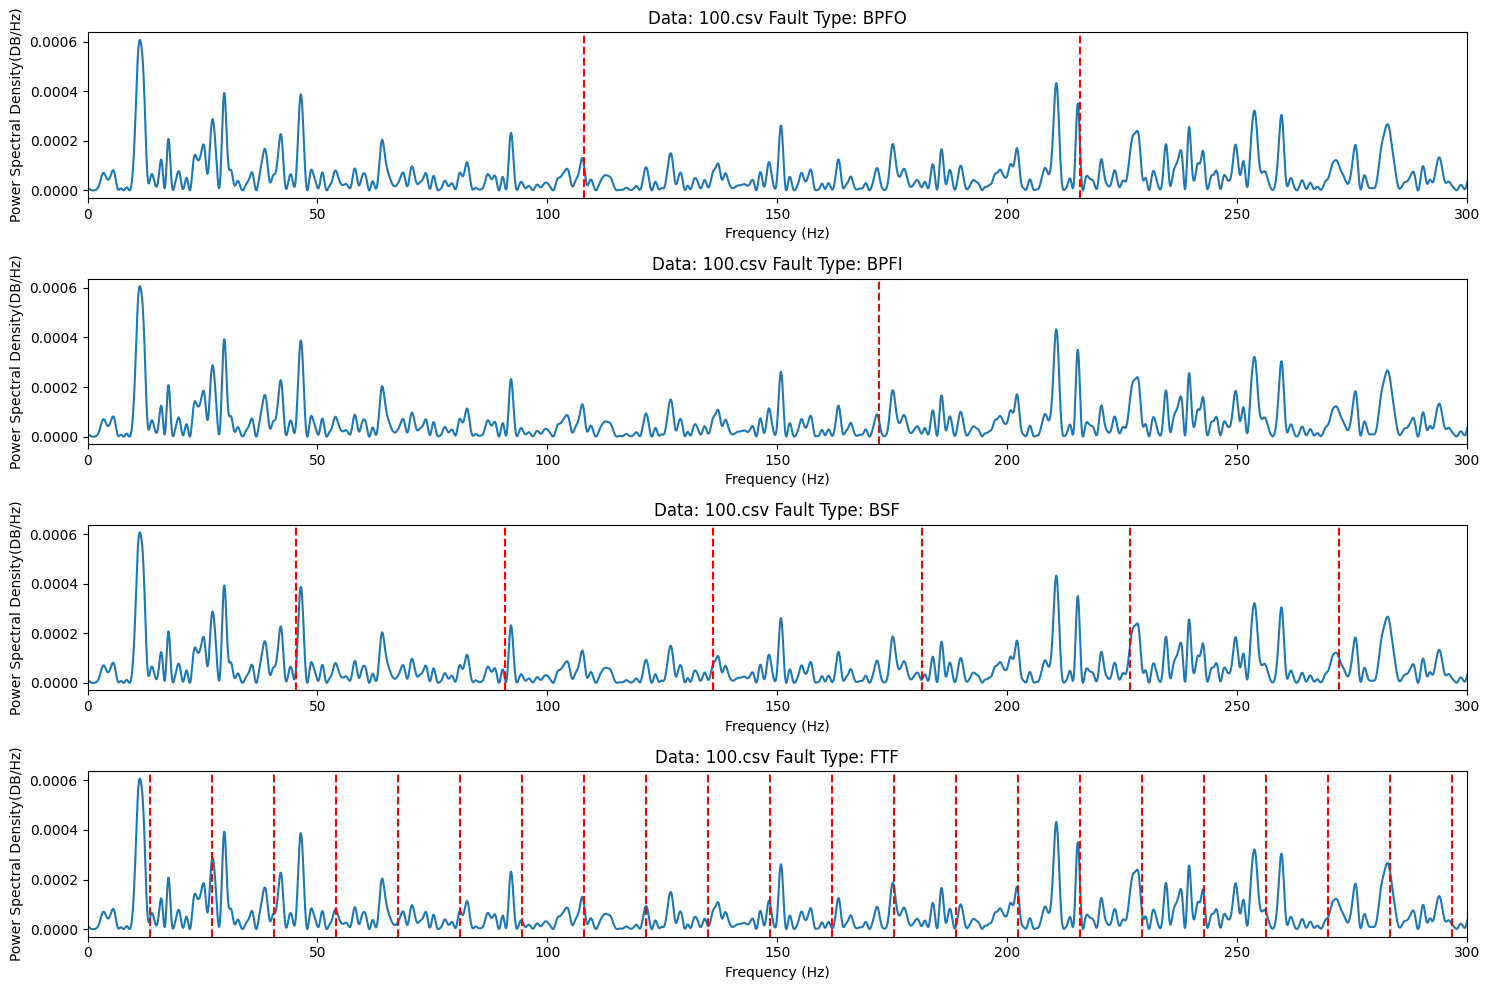

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


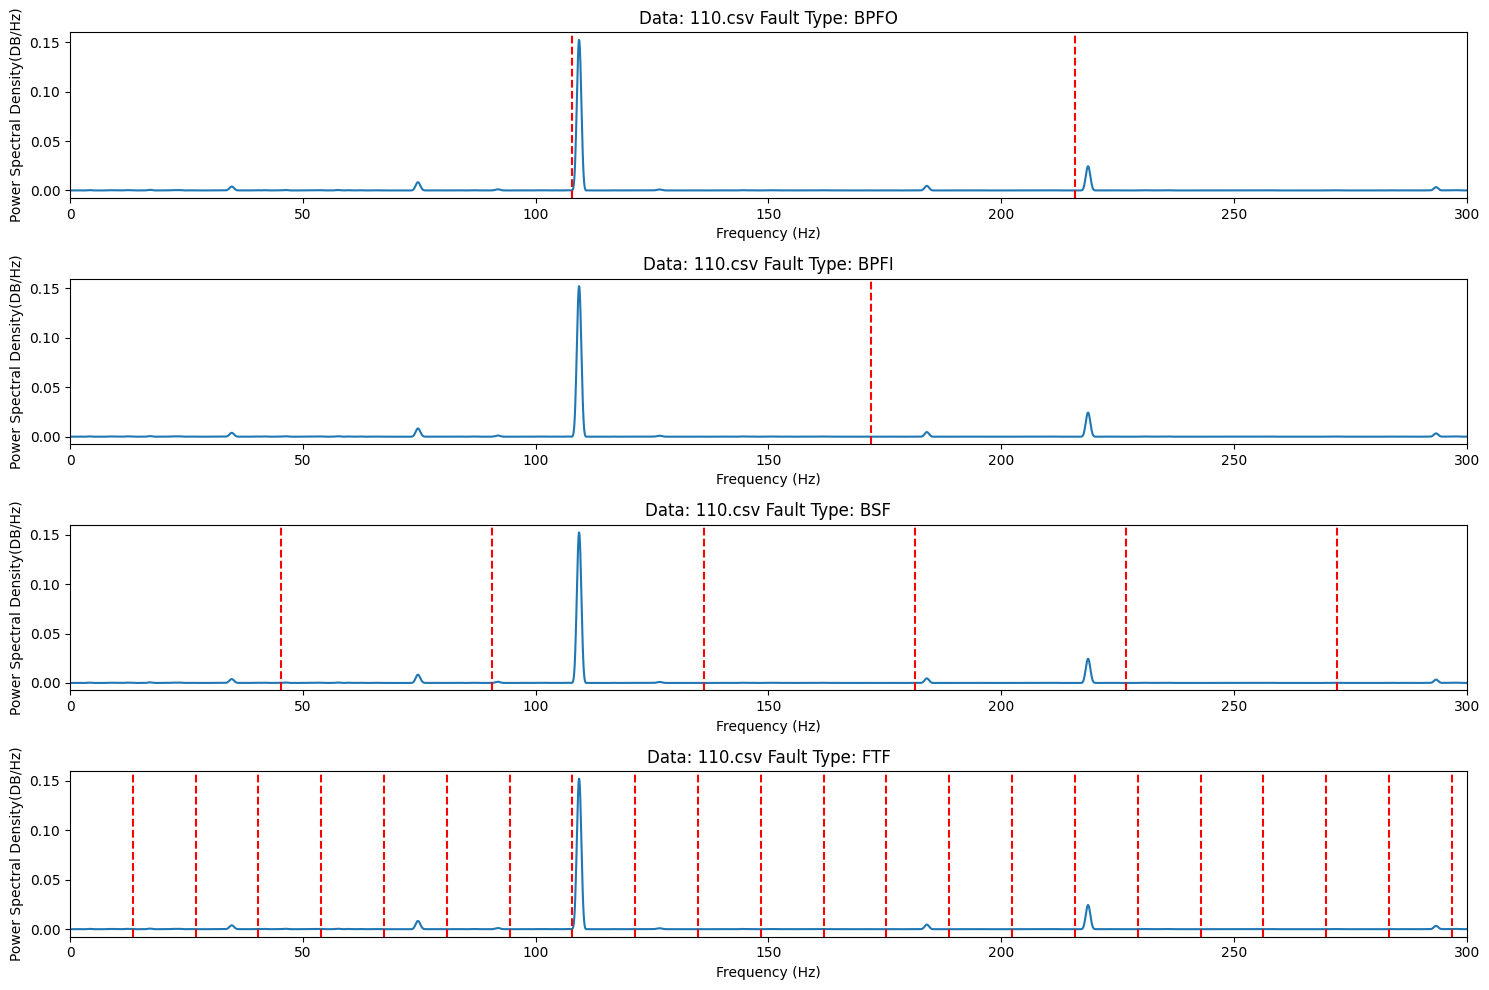

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


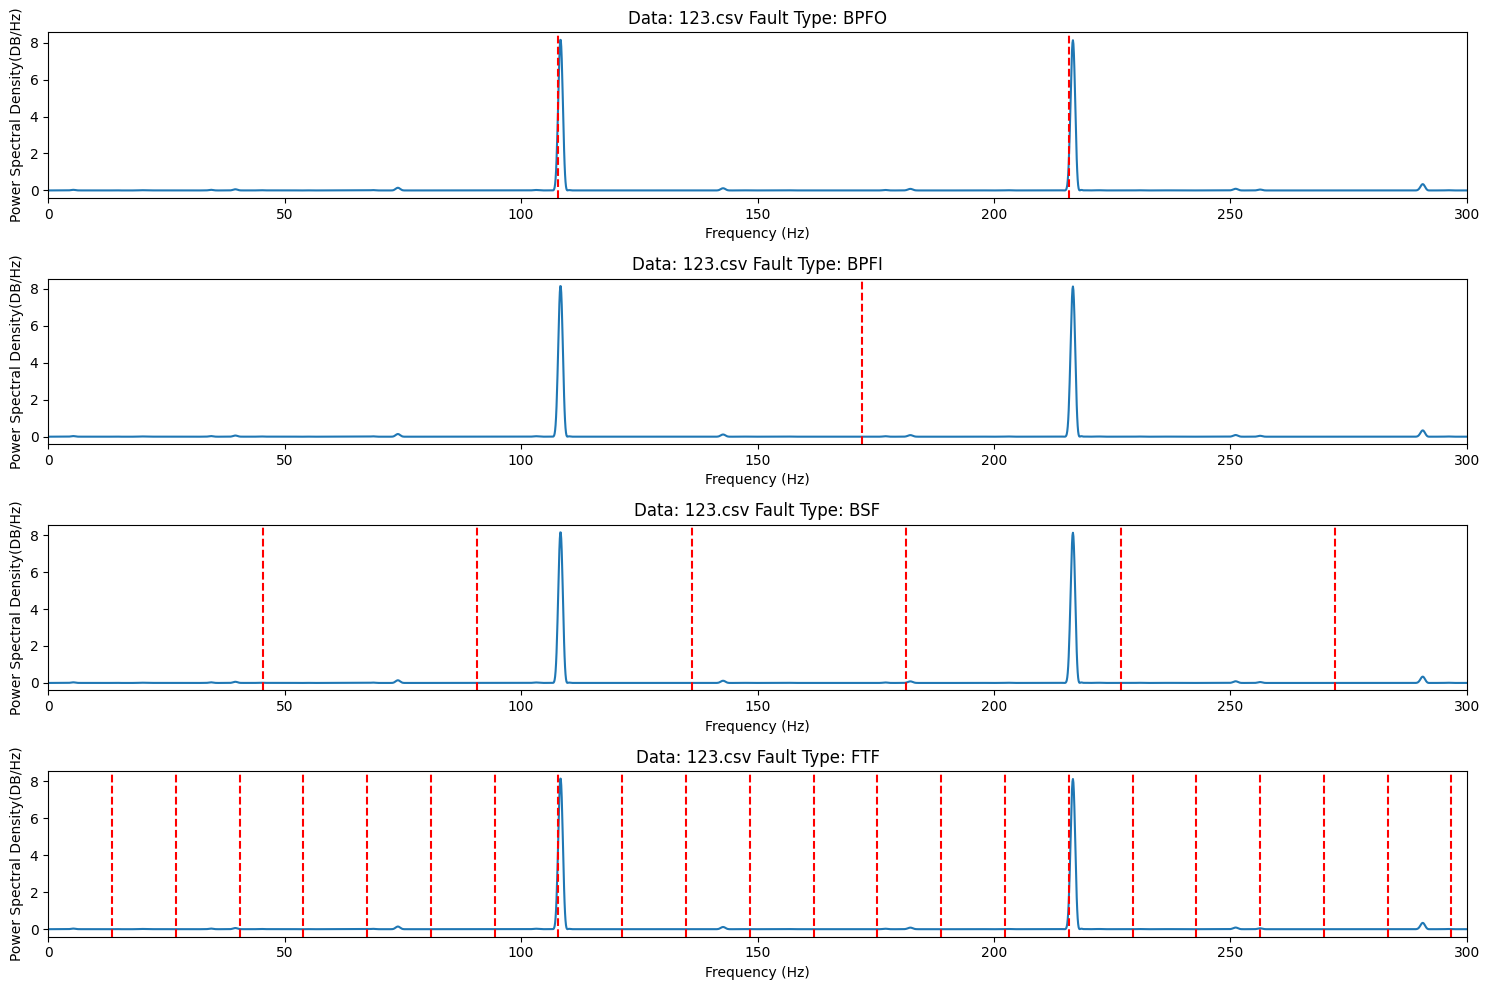

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


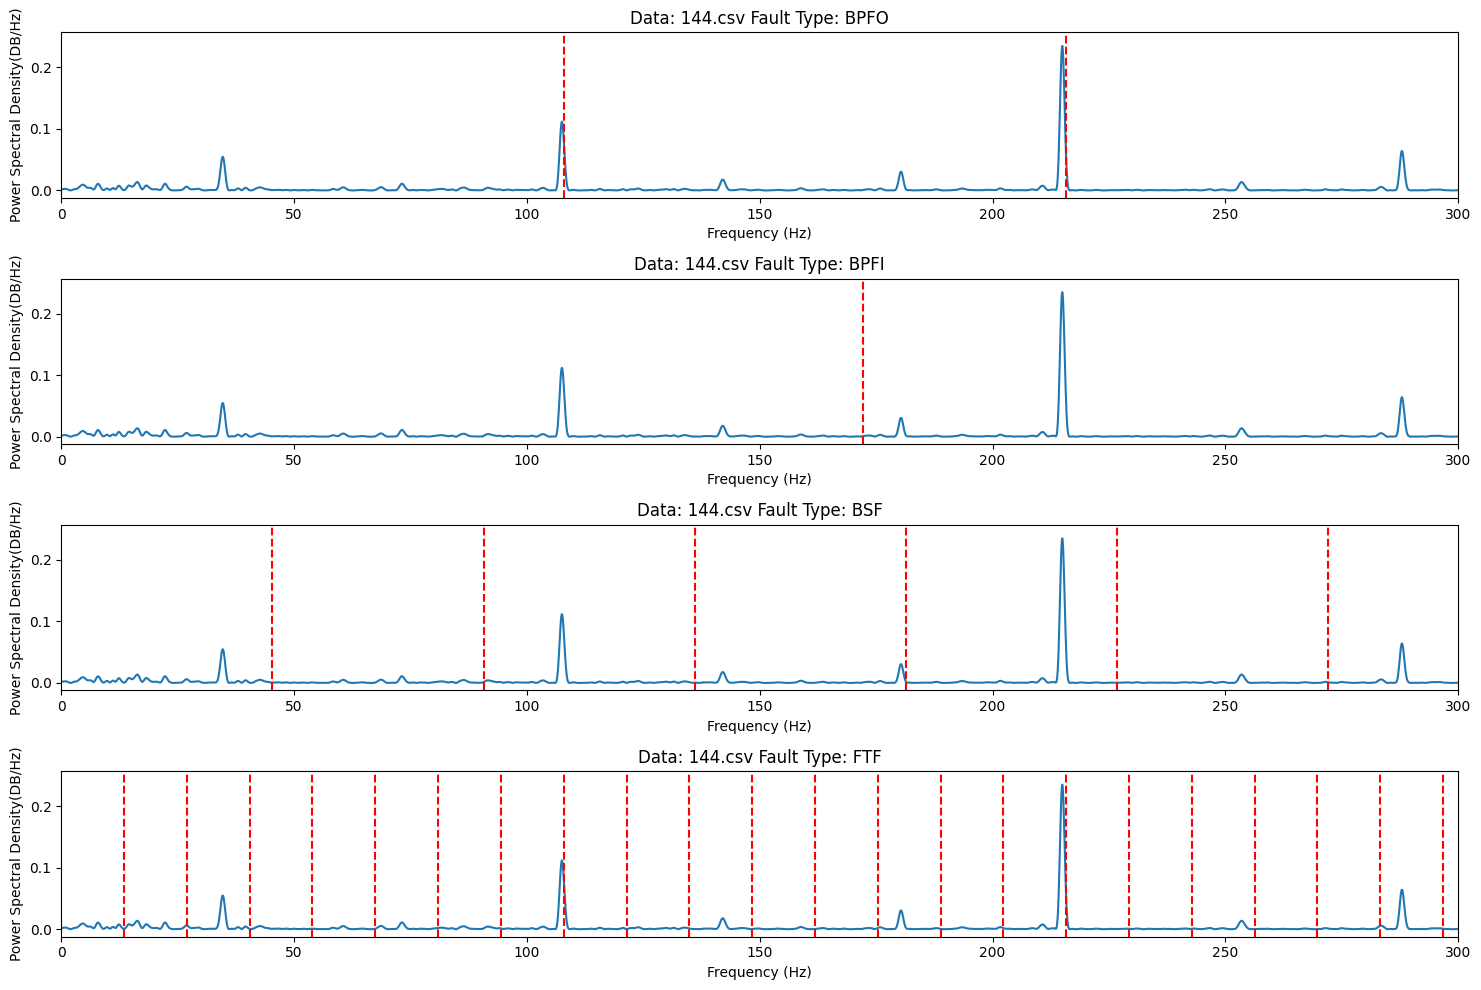

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


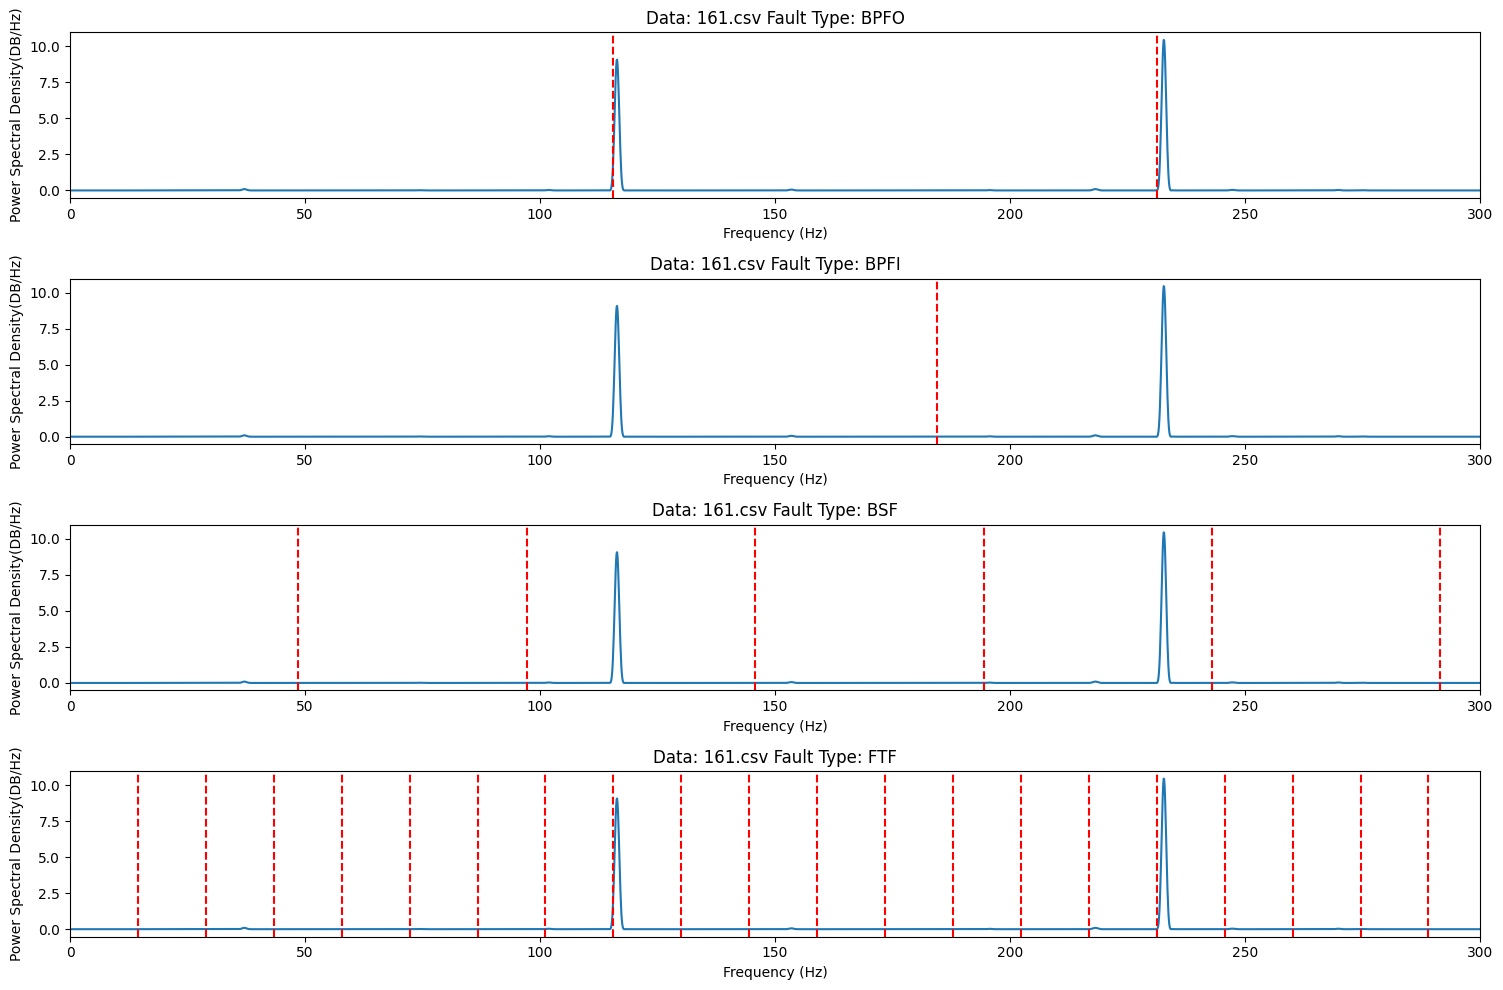

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


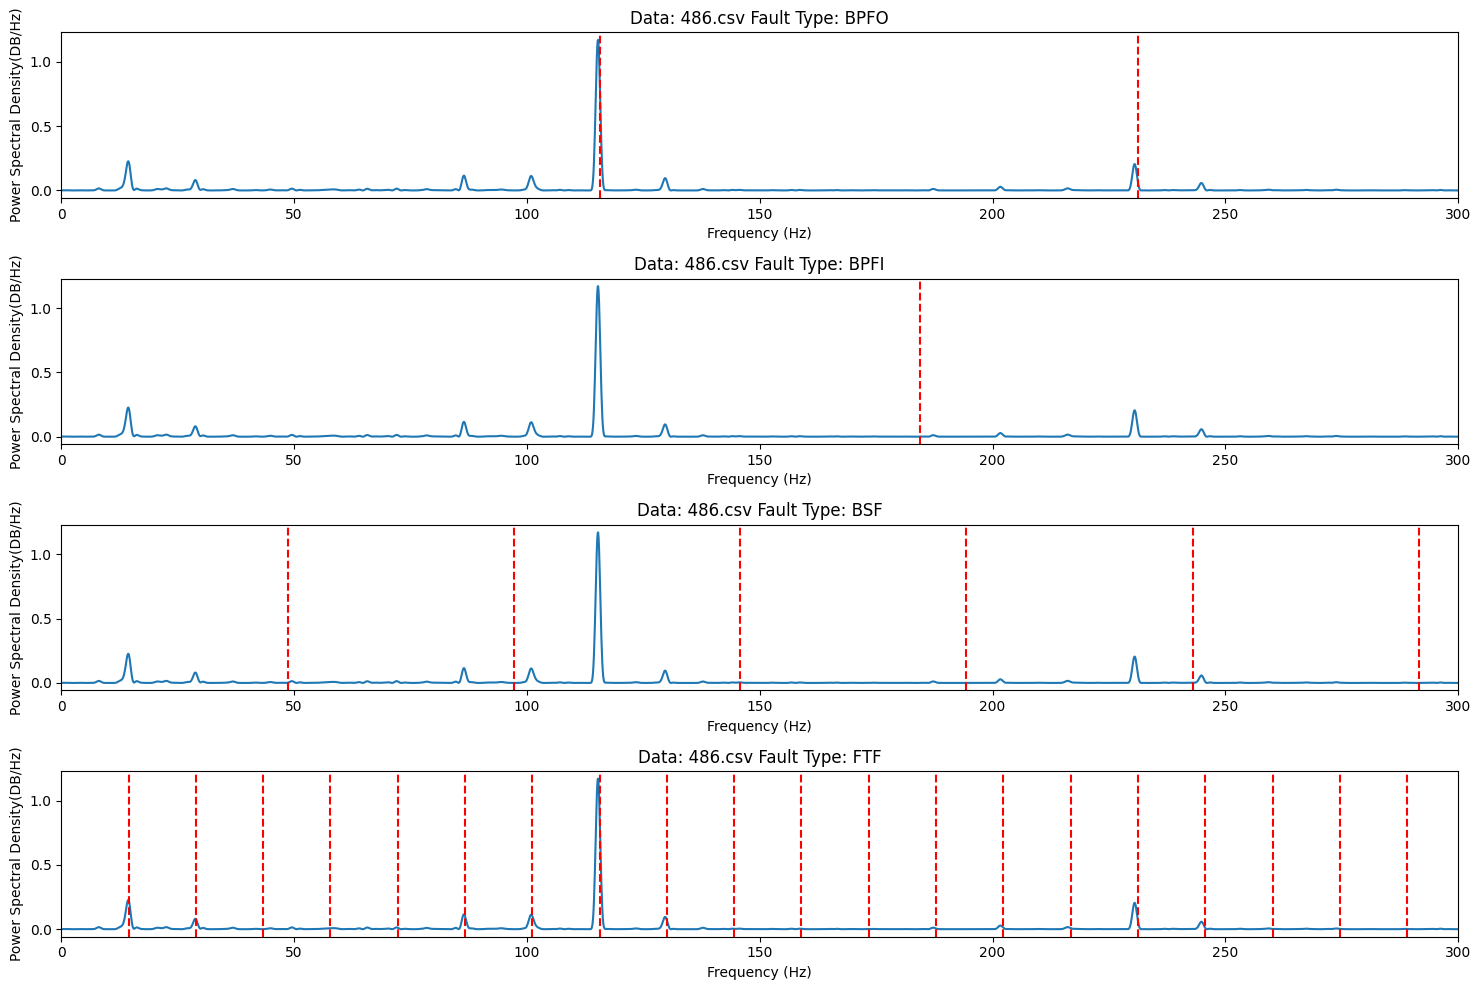

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


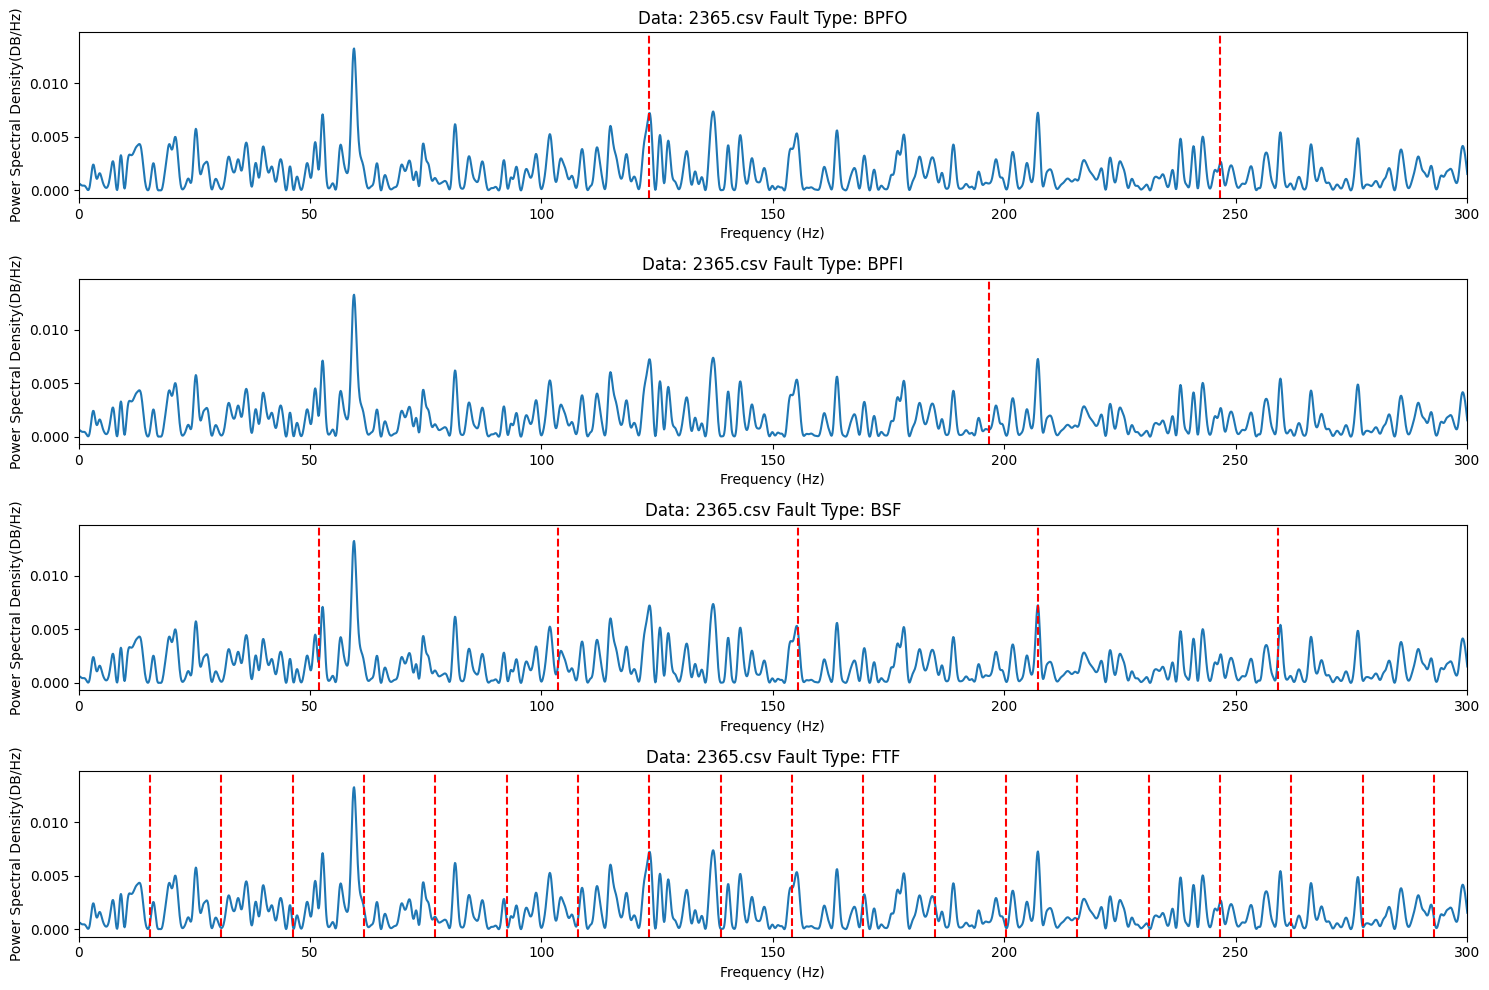

/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


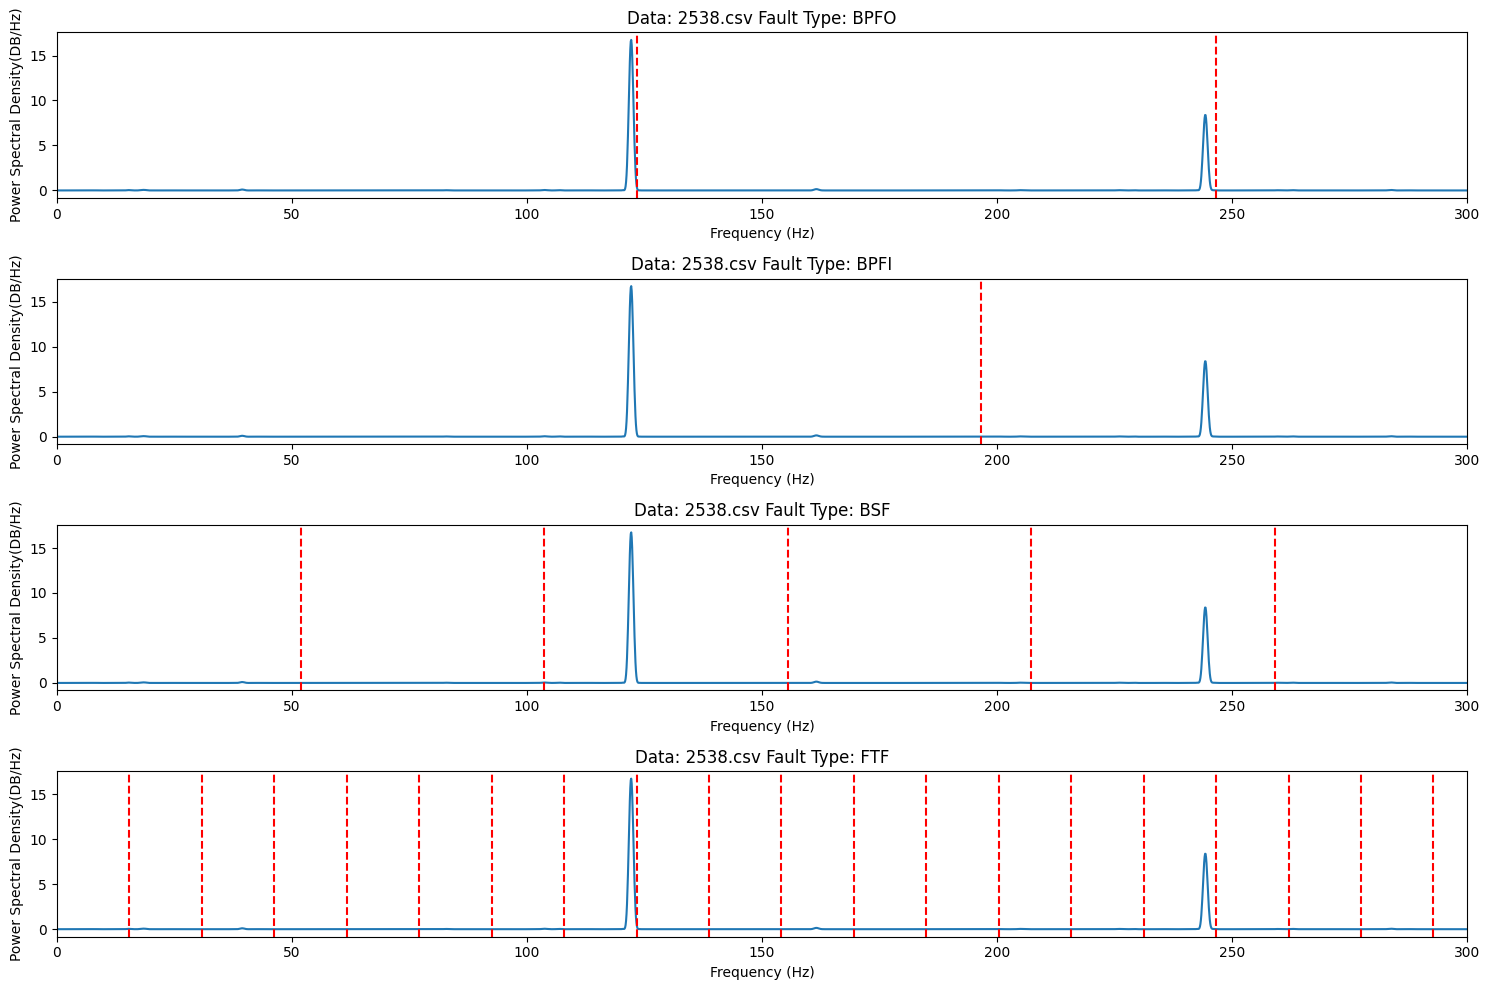

In [21]:
# 测试上述函数
# DSP_TP 2/VibrationSignal/100.csv
# DSP_TP 2/VibrationSignal/110.csv
# DSP_TP 2/VibrationSignal/123.csv
# DSP_TP 2/VibrationSignal/144.csv
# DSP_TP 2/VibrationSignal/161.csv
# DSP_TP 2/VibrationSignal/486.csv
# DSP_TP 2/VibrationSignal/2365.csv
# DSP_TP 2/VibrationSignal/2538.csv
csv_names = ['100.csv', '110.csv', '123.csv', '144.csv',
             '161.csv', '486.csv', '2365.csv', '2538.csv']
for i, csv_name in enumerate(csv_names):
    plot_all_freqs(csv_name, i)

In [22]:
'''
Copyright (c) 2015, Jerome Antoni
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright
      notice, this list of conditions and the following disclaimer in
      the documentation and/or other materials provided with the distribution

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
POSSIBILITY OF SUCH DAMAGE.
'''


from scipy.signal import firwin
from scipy.signal import lfilter
import numpy as np


def fast_kurtogram(x, fs, nlevel):
    x -= np.mean(x)
    N = 16
    fc = 0.4
    h = firwin(N+1, fc) * np.exp(2j * np.pi * np.arange(N+1)/8)
    n = np.arange(1, N+1)
    g = h[N-n] * (-1.)**n
    N = int(np.fix(3/2*N))

    h1 = firwin(N+1, 2/3 * fc) * np.exp(2j * np.pi * np.arange(N+1)/12)
    h2 = h1 * np.exp(2j * np.pi * np.arange(N+1)/6)
    h3 = h1 * np.exp(2j * np.pi * np.arange(N+1)/3)

    Kwav = K_wpQ(x, h, g, h1, h2, h3, nlevel, nlevel)

    Level_w = np.array([0])
    for i in range(1, nlevel):
        Level_w = np.append(Level_w, [i, i+np.log2(3)-1])
    Level_w = np.append(Level_w, nlevel)

    freq_w = fs*(np.arange(3*2**nlevel) /
                 (3*2**(nlevel+1)) + 1/(3*2**(2+nlevel)))
    max_level_index = np.argmax(Kwav)//Kwav.shape[1]  # 最大值所在行数
    max_kurt = np.amax(Kwav)
    level_max = Level_w[max_level_index]
    bandwidth = fs/2**(level_max+1)
    J = np.argmax(Kwav[max_level_index, :])  # 最大值所在列数

    df = np.abs(freq_w[1]-freq_w[0])
    fi = J*df
    fi = fi + bandwidth/2
    level_max = np.round(level_max*10)/10

    print('Max Level: {}'.format(level_max))
    print('Max Kurtosis: {}'.format(max_kurt))
    print('Cental Freq: {}'.format(fi))
    print('Bandwidth: {}'.format(bandwidth))
    # return Kwav, Level_w, freq_w
    return Kwav, Level_w, freq_w, fi, bandwidth


def kurt(x):
    eps = 2.2204e-16
    if np.all(x == 0):
        return 0
    x -= np.mean(x)
    E = np.mean(np.abs(x)**2)
    if E < eps:
        return 0
    K = np.mean(np.abs(x)**4) / E**2
    if np.all(np.isreal(x)):
        K -= 3
    else:
        K -= 2
    return K


def K_wpQ(x, h, g, h1, h2, h3, nlevel, level):
    KD, KQ = K_wpQ_local(x, h, g, h1, h2, h3, nlevel, level)
    K = np.zeros((2*nlevel, 3*2**nlevel))
    K[0, :] = KD[0, :]
    for i in np.arange(1, nlevel):  # 下采样
        K[2*i-1, :] = KD[i, :]
        K[2*i, :] = KQ[i-1, :]
    K[2*nlevel-1, :] = KD[nlevel, :]
    return K


def length(x):
    return np.amax(x.shape)


def K_wpQ_local(x, h, g, h1, h2, h3, nlevel, level):
    a, d = DBFB(x, h, g)
    N = length(a)
    d = d*np.array([(-1)**(np.arange(1, N+1))]).T

    Lh = h.shape[0]
    Lg = g.shape[0]

    K1 = kurt(a[Lh-1:])
    K2 = kurt(d[Lg-1:])

    if level > 2:
        a1, a2, a3 = TBFB(a, h1, h2, h3)
        d1, d2, d3 = TBFB(d, h1, h2, h3)

        Ka1 = kurt(a1[Lh-1:])
        Ka2 = kurt(a2[Lh-1:])
        Ka3 = kurt(a3[Lh-1:])
        Kd1 = kurt(d1[Lh-1:])
        Kd2 = kurt(d2[Lh-1:])
        Kd3 = kurt(d3[Lh-1:])
    else:
        Ka1 = 0
        Ka2 = 0
        Ka3 = 0
        Kd1 = 0
        Kd2 = 0
        Kd3 = 0
    if level == 1:
        K = np.concatenate((K1*np.ones(3), K2*np.ones(3)))
        KQ = np.array([Ka1, Ka2, Ka3, Kd1, Kd2, Kd3])
    if level > 1:
        Ka, KaQ = K_wpQ_local(a, h, g, h1, h2, h3, nlevel, level-1)
        Kd, KdQ = K_wpQ_local(d, h, g, h1, h2, h3, nlevel, level-1)

        K1 *= np.ones(length(Ka))
        K2 *= np.ones(length(Kd))
        K = np.vstack((np.concatenate([K1, K2]), np.hstack((Ka, Kd))))

        Long = int(length(KaQ)/3)
        Ka1 *= np.ones(Long)
        Ka2 *= np.ones(Long)
        Ka3 *= np.ones(Long)
        Kd1 *= np.ones(Long)
        Kd2 *= np.ones(Long)
        Kd3 *= np.ones(Long)

        KQ = np.vstack(
            (np.concatenate([Ka1, Ka2, Ka3, Kd1, Kd2, Kd3]), np.hstack((KaQ, KdQ))))

    if level == nlevel:
        K1 = kurt(x)
        K = np.vstack((K1*np.ones(length(K)), K))
        a1, a2, a3 = TBFB(x, h1, h2, h3)

        Ka1 = kurt(a1[Lh-1:])
        Ka2 = kurt(a2[Lh-1:])
        Ka3 = kurt(a3[Lh-1:])

        Long = int(length(KQ)/3)

        Ka1 *= np.ones(Long)
        Ka2 *= np.ones(Long)
        Ka3 *= np.ones(Long)
        KQ = np.vstack((np.concatenate([Ka1, Ka2, Ka3]), KQ[:-2, :]))
    return K, KQ


def TBFB(x, h1, h2, h3):  # 高通
    x = x.flatten()
    N = length(x)
    a1 = lfilter(h1, 1, x)
    a1 = a1[2:N:3]
    a1 = np.atleast_2d(a1).T

    a2 = lfilter(h2, 1, x)
    a2 = a2[2:N:3]
    a2 = np.atleast_2d(a2).T

    a3 = lfilter(h3, 1, x)
    a3 = a3[2:N:3]
    a3 = np.atleast_2d(a3).T
    return a1, a2, a3


def DBFB(x, h, g):  # 高通和低通
    x = x.flatten()
    N = length(x)

    a = lfilter(h, 1, x)
    a = a[1:N:2]
    a = np.atleast_2d(a).T

    d = lfilter(g, 1, x)
    d = d[1:N:2]
    d = np.atleast_2d(d).T
    return a, d


def binary(i, k):

    k = int(k)

    if i > 2**k:
        raise ValueError('i must be such that i < 2^k')

    a = np.zeros(k)

    temp = i

    for l in np.arange(k)[::-1]:
        a[-(l+1)] = np.fix(temp / 2**l)
        temp -= a[-(l+1)] * 2 ** l

    return a


def find_wav_kurt(x, h, g, h1, h2, h3, Sc, Fr, opt, Fs):
    level = np.fix(Sc) + (np.remainder(Sc, 1) >= 0.5) * (np.log2(3)-1)

    Bw = 2**(-level - 1)
    freq_w = np.arange(2**level) / (2**(level+1)) + Bw/2
    J = np.argmin(np.abs(freq_w - Fr))
    fc = freq_w[J]
    i = np.round((fc/Bw - 1/2))

    if np.remainder(level, 1) == 0:

        acoeff = binary(i, level)
        bcoeff = np.array([])
        temp_level = level

    else:

        i2 = np.fix(i/3)
        temp_level = np.fix(level) - 1
        acoeff = binary(i2, temp_level)
        bcoeff = i - i2 * 3

    acoeff = acoeff[::-1]

    c = K_wpQ_filt(x, h, g, h1, h2, h3, acoeff, bcoeff, temp_level)

    kx = _kurt(c, opt)

    sig = np.median(np.abs(c)) / np.sqrt(np.pi / 2)

    threshold = sig * np.sqrt((-2*1**2) * np.log(1 - 0.999))

    return c, Bw, fc, i


def K_wpQ_filt(x, h, g, h1, h2, h3, acoeff, bcoeff, level=None):

    nlevel = acoeff.size

    L = np.floor(np.log2(np.amax(x.shape)))

    if level == None:
        if nlevel >= L:
            raise ValueError('nlevel must be smaller')

        level = nlevel

    x = np.atleast_2d(x.flatten()).T

    if nlevel == 0:
        if bcoeff.size == 0:
            c = x
        else:
            c1, c2, c3 = _TBFB(x, h1, h2, h3)

            if bcoeff == 0:
                c = c1[h1.size - 1:]
            elif bcoeff == 1:
                c = c2[h2.size - 1:]
            elif bcoeff == 2:
                c = c3[h3.size - 1:]

    else:

        c = K_wpQ_filt_local(x, h, g, h1, h2, h3, acoeff, bcoeff, level)

    return c


def K_wpQ_filt_local(x, h, g, h1, h2, h3, acoeff, bcoeff, level):

    a, d = _DBFB(x, h, g)

    N = a.size

    level = int(level)

    d = d*np.array([(-1)**(np.arange(1, N+1))]).T

    if level == 1:
        if bcoeff.size == 0:
            if acoeff[level-1] == 0:
                c = a[h.size-1:]
            else:
                c = d[g.size-1:]
        else:
            if acoeff[level-1] == 0:
                c1, c2, c3 = _TBFB(a, h1, h2, h3)
            else:
                c1, c2, c3 = _TBFB(d, h1, h2, h3)

            if bcoeff == 0:
                c = c1[h1.size - 1:]
            elif bcoeff == 1:
                c = c2[h2.size - 1:]
            elif bcoeff == 2:
                c = c3[h3.size - 1:]

    if level > 1:
        if acoeff[level-1] == 0:
            c = K_wpQ_filt_local(a, h, g, h1, h2, h3, acoeff, bcoeff, level-1)
        else:
            c = K_wpQ_filt_local(d, h, g, h1, h2, h3, acoeff, bcoeff, level-1)

    return c

Max Level: 5.0
Max Kurtosis: 4.727322791301832
Cental Freq: 10600.0
Bandwidth: 400.0


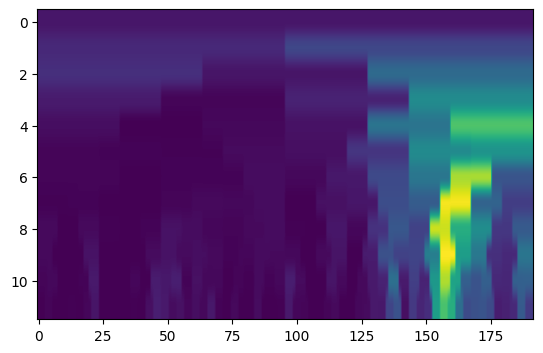

In [23]:
def get_array_from_csv(csv_name):
    data = pd.read_csv(f'./VibrationSignal/{csv_name}')
    Horizontal_vibration_signals = data.loc[:, 'Horizontal_vibration_signals']
    Horizontal_vibration_signals_array = Horizontal_vibration_signals.to_numpy()
    return Horizontal_vibration_signals_array


Kwav, Level_w, freq_w, fi, bandwidth = fast_kurtogram(
    get_array_from_csv('100.csv'), fs, 6)
plt.imshow(np.clip(Kwav, 0, np.inf), aspect=10)

Max Level: 9.6
Max Kurtosis: 2.0970288528972336
Cental Freq: 3875.0000000000005
Bandwidth: 16.666666666666668


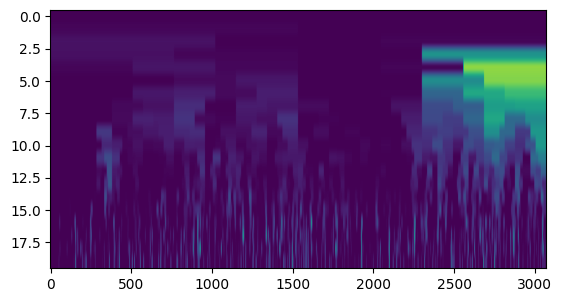

In [24]:
Kwav, Level_w, freq_w, fi, bandwidth = fast_kurtogram(
    get_array_from_csv('2365.csv'), fs, 10)
plt.imshow(np.clip(Kwav, 0, np.inf), aspect=80)

In [25]:
# 对信号带通滤波（中心频率 fi，带宽 bandwidth）
from scipy.signal import butter, filtfilt


def bandpass_filter(signal, fi, bandwidth, fs):
    print(f'in bandpass_filter, len: {len(signal)}')
    # Calculate the low and high cutoff frequencies
    low_cutoff = fi - bandwidth/2
    high_cutoff = fi + bandwidth/2

    # Normalize the cutoff frequencies
    nyquist_freq = 0.5 * fs
    print(f'bandpass_filter, low: {low_cutoff}, high: {high_cutoff}')
    low_cutoff_norm = low_cutoff / nyquist_freq
    high_cutoff_norm = high_cutoff / nyquist_freq

    # Design the Butterworth bandpass filter
    order = 4  # Filter order
    print(f'In bandpass, low: {low_cutoff_norm}, high: {high_cutoff_norm}')
    b, a = butter(order, [low_cutoff_norm, high_cutoff_norm], btype='band')

    # Apply the filter to the signal
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal


# Example usage
filtered_signal = bandpass_filter(
    Horizontal_vibration_signals_array, fi, bandwidth, fs)

print(Horizontal_vibration_signals_array.shape)
print(filtered_signal.shape)
# filter_signal 包络分析并绘图
env = envelope(filtered_signal, fs)
freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)

in bandpass_filter, len: 32768
bandpass_filter, low: 3866.666666666667, high: 3883.333333333334
In bandpass, low: 0.30208333333333337, high: 0.30338541666666674
(32768,)
(32768,)


/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


In [26]:
# 将上面部分函数封装成一个函数，输入 csv 名称，绘制出四种故障的频率图像
def plot_all_freqs_kurtosis(csv_name, data_no, fs):
    data = pd.read_csv(f'./VibrationSignal/{csv_name}')
    Horizontal_vibration_signals = data.loc[:, 'Horizontal_vibration_signals']
    Horizontal_vibration_signals_array = Horizontal_vibration_signals.to_numpy()

    Kwav, Level_w, freq_w, fi, bandwidth = fast_kurtogram(
        Horizontal_vibration_signals_array, fs, 13)
    # 带通滤波
    # filtered_signal = bandpass_filter(
    # Horizontal_vibration_signals_array, fi, bandwidth, fs)
    # 求包络
    env = envelope(Horizontal_vibration_signals_array, fs)
    # 计算功率谱密度
    # env_anal = envelope_analysis(
    #     Horizontal_vibration_signals, fs, fi - bandwidth/2, fi + bandwidth/2, order=7)
    freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)

    # plot_fft(freqs, fft_vals, data_No=0)

    # freqs, psd = power_spectral_density(
    #     Horizontal_vibration_signals_array, fs, nfft=nfftto)
    # plot_power_spectral_density(freqs, psd, fs, data_No=0)

    # env = envelope(Horizontal_vibration_signals_array, fs)
    # freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)
    # plot_power_spectral_density(freqs_env, psd_env, fs, data_No=0)

    # freqs, kurtosis = spectral_kurtosis(Horizontal_vibration_signals_array, fs)
    # max_kurtosis_idx = np.argmax(kurtosis)
    # low_freq = freqs[max_kurtosis_idx - 5]
    # high_freq = freqs[max_kurtosis_idx + 5]
    # env = envelope_analysis(
    #     Horizontal_vibration_signals_array, fs, low_freq, high_freq)
    # freqs_env, psd_env = power_spectral_density(env, fs, nfft=nfftto)
    # plot_power_spectral_density(freqs_env, psd_env, fs, data_No=0)

    fig, axs = plt.subplots(4, 1, figsize=(15, 10))
    axs = axs.ravel()

    for i, (name, type) in enumerate(fault_types.items()):
        plot_power_spectral_density_all(
            freqs_env, psd_env, fs, data_No=data_no, fault_type=type, ax=axs[i])
        axs[i].set_title(f'Data: {csv_name} Fault Type: {name}')

    plt.tight_layout()
    plt.show()

Max Level: 5.0
Max Kurtosis: 4.727322791301832
Cental Freq: 10600.0
Bandwidth: 400.0


/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


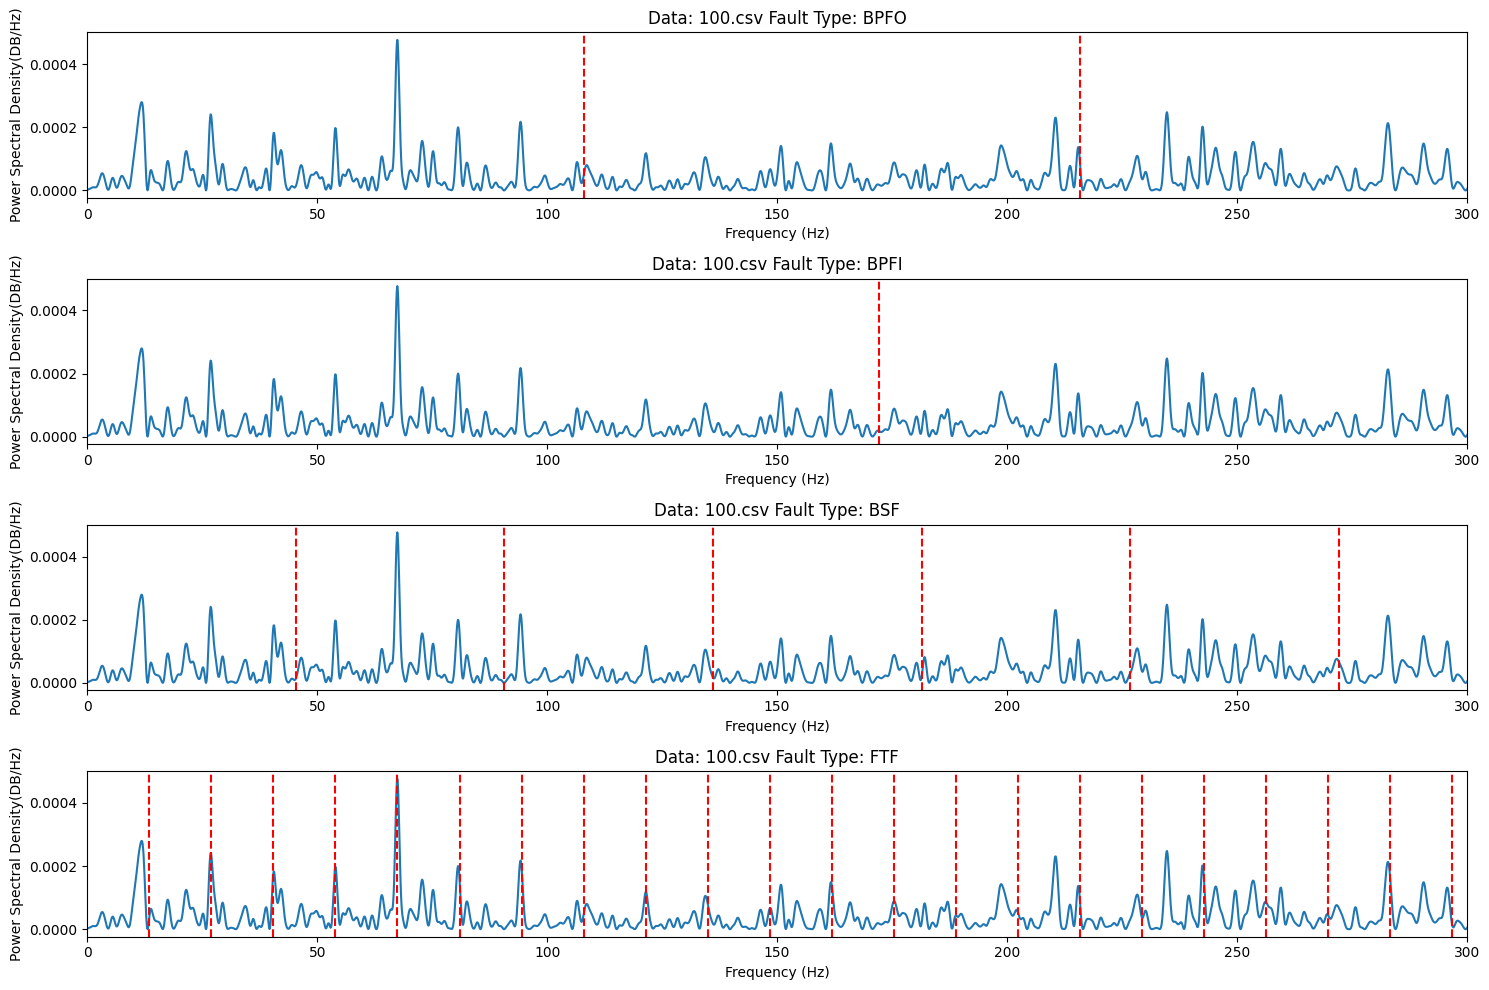

Max Level: 9.6
Max Kurtosis: 2.0970288528972336
Cental Freq: 3875.0000000000005
Bandwidth: 16.666666666666668


/Users/florian/opt/anaconda3/envs/cours/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256000 is greater than input length  = 32768, using nperseg = 32768
  warnings.warn('nperseg = {0:d} is greater than input length '


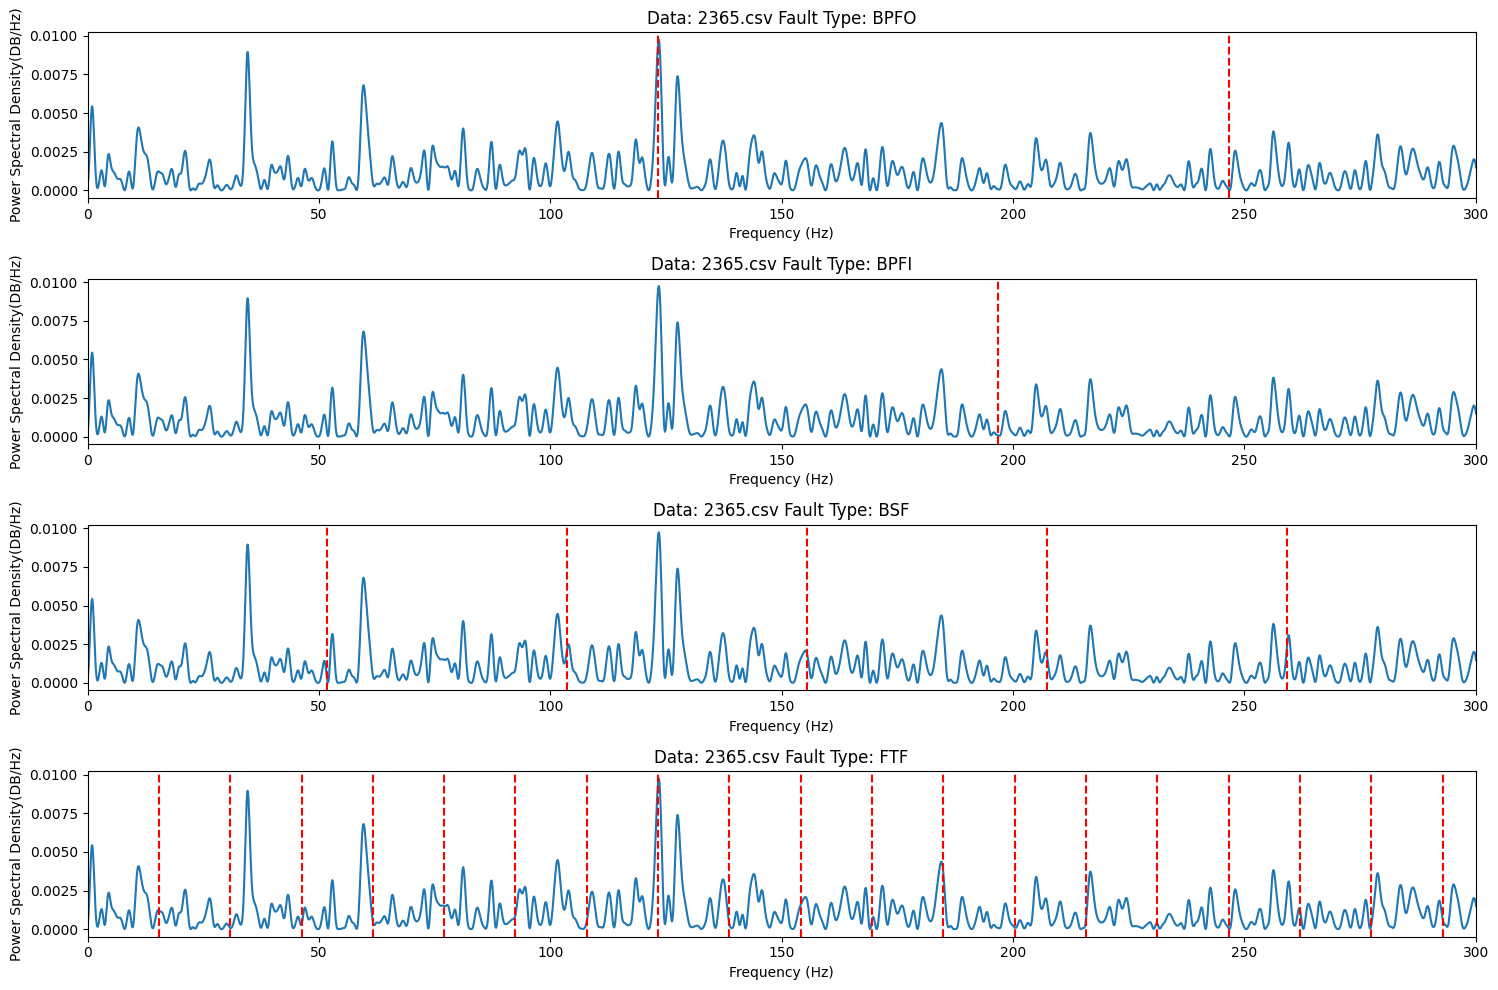

In [27]:
plot_all_freqs_kurtosis('100.csv', 0, fs)
plot_all_freqs_kurtosis('2365.csv', 6, fs)